In [1]:
import pickle as pkl
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy.optimize import curve_fit
# import pylandau as pland
# import ROOT
import scipy.ndimage as ndimage
import numpy.ma as ma
from functions_CONNIE import *
from ROOT import TF1, TGraph, TLegend, TFile, TTree

def gaussian(x, a, mean, sigma, y_move):
    return a * np.exp(-((x - mean)**2 / (2 * sigma**2))) - y_move

# def gaussian(x, a, mean, sigma):
#     return a * np.exp(-((x - mean)**2 / (2 * sigma**2))) 

def diffution_curve(z, alpha, beta):
    return np.sqrt(np.abs(alpha * np.log(1 - (beta * z))))
    
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import A4, letter
from reportlab.lib.utils import ImageReader

In [2]:
import matplotlib.colors


plt.rcParams.update({
    "image.origin": "lower",
    "image.aspect": 1,
    #"text.usetex": True,
    "grid.alpha": .5,
    "axes.linewidth":2,
    "lines.linewidth" : 1,
    "font.size":    15.0,
    "xaxis.labellocation": 'right',  # alignment of the xaxis label: {left, right, center}
    "yaxis.labellocation": 'top',  # alignment of the yaxis label: {bottom, top, center}
    "xtick.top":           True ,  # draw ticks on the top side
    "xtick.major.size":    8    ,# major tick size in points
    "xtick.minor.size":    4      ,# minor tick size in points
    "xtick.direction":     'in',
    "xtick.minor.visible": True,
    "ytick.right":           True ,  # draw ticks on the top side
    "ytick.major.size":    8    ,# major tick size in points
    "ytick.minor.size":    4      ,# minor tick size in points
    "ytick.direction":     'in',
    "ytick.minor.visible": True,
    "ytick.major.width":   2   , # major tick width in points
    "ytick.minor.width":   1 ,
    "xtick.major.width":   2   , # major tick width in points
    "xtick.minor.width":   1 ,
    "legend.framealpha": 0 ,
    "legend.loc": 'best',

})

ColorMap = 'jet'
Norm = matplotlib.colors.LogNorm(vmin=10**-1, vmax=5 * 10**0)

In [3]:
# path = './Diccionarios_Espetro_Muones/dict_straight_muons_Extensions_1_to_4_Imgs_189_Elip_0.9_Sol_0.65_Skirts_0_NSIGMAS_13_KeV__NSAMP324.pkl'
# path = './Diccionarios_Espetro_Muones/dict_straight_muons_Extensions_1_to_4_Imgs_189_Elip_0.9_Sol_0.65_Skirts_0_NSIGMAS_20_KeV__NSAMP324.pkl'
path = './dict_muons_NSAMP400_CONNIE_RUNID_116_NIMG_684_NSIG_4_SOL_0.65_ELIP_0.65_DEDL_1300_SIZE_1022x420_KeV_new.pkl'


histogram = open(path, 'rb')
data_histogram = pkl.load(histogram)
histogram.close()

#### Visualizar las keys del diccionario ####
print('Las unidades de los datos están en: ', data_histogram['Energy_Units'])
print('Llaves principales del diccionario: ', data_histogram.keys())
print('Llaves secuandarias por extensión: ', data_histogram['extension_1'].keys(), end='\n\n')
# print(type(data_histogram['extension_1']['all_events']))
# data_muons_extension_1 = data_histogram['extension_1']
# data_muons_extension_2 = data_histogram['extension_2']
# data_muons_extension_4 = data_histogram['extension_4']
Ext = 1

n_muons = data_histogram['All_Muons_Detected']
print('Se detectaron ', n_muons, ' muones (contando las 3 extensiones)')
DF_muons, list_datamask = DataFrame_muons(data_histogram, extension=Ext)

Las unidades de los datos están en:  2
Llaves principales del diccionario:  dict_keys(['Num_Images', 'All_Muons_Detected', 'Energy_Units', 'Elipcidad', 'Solidity', 'extension_1'])
Llaves secuandarias por extensión:  dict_keys(['charge', 'deltaEL', 'deltaL', 'all_events', 'theta', 'phi', 'elip', 'sol', 'all_events_elip', 'all_events_sol', 'datamasked'])

Se detectaron  8549  muones (contando las 3 extensiones)


# Extension 1

### Muones verticales

#### DataFrame y visualización

In [202]:
### Se crea el dataframe y se selecciona un rango de datos ###
Ext = 1
DF_muons, list_datamask = DataFrame_muons(data_histogram, extension=Ext)
# display(DF_muons[450:500])
list_newmatrix = []
list_indexs =[]
# range_in_phi = DF_muons[DF_muons['Phi (Deg)'].between(85, 95)] # Verticales arriba
range_in_phi = DF_muons[DF_muons['Phi (Deg)'].between(265, 275)] # Verticales abajo

for index in range_in_phi.index:
    # print(index)
    list_newmatrix.append(list_datamask[index])
    list_indexs.append(index)

print(f'Muons detected in the range: {len(list_newmatrix)}')
print(list_indexs)
list_phi_ext1 = data_histogram['extension_' + str(Ext)]['phi']
list_mask_rot = []

list_listsnxny = []

for index in list_indexs[:]:
    datamask = list_datamask[index]
    ylen, xlen = datamask.shape
    list_nxny = []

    data_mask_zeros = np.empty((ylen + 90, xlen+50))
    data_mask_zeros[:] = 0
    ylen_zeros, xlen_zeros = data_mask_zeros.shape
    # print(data_mask_zeros.shape)
    
    ### Angle rot ##
    phi_rot = np.pi/2 - list_phi_ext1[index]
    # print(phi_rot, phi_rot + list_phi_ext1[index])

    # print('shape original: ', xlen, ylen)
    # print('shape zeros: ', xlen_zeros, ylen_zeros)

    for y_bin in range(0, ylen):
        for x_bin in range(0, xlen):
            if datamask[y_bin][x_bin] != 0:
                nx, ny = pixel_rot(x_bin=x_bin, x0=0, y_bin=y_bin, y0=0, theta= phi_rot)
                list_nxny.append((nx + 10, ny))
                # print(nx, ny)
                data_mask_zeros[ny][nx+10] = datamask[y_bin][x_bin]

    list_listsnxny.append(list_nxny)
    label_img, nlabels_img = sk.measure.label(data_mask_zeros > 0, connectivity=2, return_num=True)
    loc = nd.find_objects(label_img == 1)[0]
    mask_rot = np.invert(label_img==1)
    # data_mask_rot = ma.masked_array(data_mask_zeros, mask_rot)
    data_mask_rot = ma.masked_array(data_mask_zeros[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_rot[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])

    list_mask_rot.append(data_mask_rot)
    # print('Shape rot: ', data_mask_rot.shape[1], data_mask_rot.shape[0])
    
    # plt.imshow(data_mask_rot)
    # plt.show()

# print(list_mask_rot)
#     

Muons detected in the range: 369
[1, 24, 56, 63, 68, 75, 93, 96, 111, 189, 247, 282, 294, 318, 346, 357, 393, 396, 398, 415, 423, 440, 454, 460, 518, 544, 559, 572, 577, 596, 605, 654, 733, 745, 782, 851, 894, 895, 932, 935, 940, 941, 954, 960, 969, 996, 1015, 1042, 1083, 1084, 1095, 1096, 1113, 1126, 1159, 1170, 1214, 1215, 1229, 1233, 1246, 1259, 1275, 1276, 1285, 1318, 1323, 1329, 1332, 1352, 1410, 1423, 1532, 1560, 1571, 1609, 1679, 1704, 1761, 1777, 1784, 1788, 1835, 1859, 1867, 1883, 1918, 1922, 1925, 1943, 1967, 2107, 2155, 2178, 2203, 2212, 2272, 2289, 2343, 2354, 2359, 2361, 2389, 2480, 2486, 2510, 2562, 2570, 2617, 2683, 2776, 2780, 2787, 2793, 2825, 2828, 2832, 2851, 2903, 2904, 2944, 2954, 2961, 2985, 3014, 3037, 3038, 3069, 3092, 3095, 3127, 3128, 3158, 3170, 3197, 3204, 3241, 3254, 3267, 3271, 3283, 3302, 3367, 3377, 3394, 3395, 3454, 3482, 3524, 3525, 3538, 3540, 3575, 3577, 3594, 3689, 3719, 3731, 3800, 3826, 3883, 3885, 3894, 3903, 3930, 3940, 3944, 3950, 3955, 3973, 3

,Solidity,Elipticity,Theta (Deg),Phi (Deg),Charge (KeV),l (cm),dEdL (KeV/cm)
Muon ID,,,,,,,
1,0.742331,0.859629,46.618161,273.38655,1.196825,0.098274,12.178488


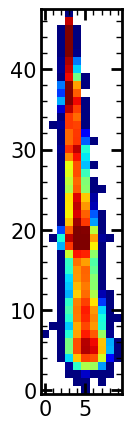

In [203]:
n_label = 1
display(DF_muons.iloc[[n_label]])

figure , axs = plt.subplots(1,1,figsize=[5,5])
# axs.imshow(list_mask_rot[n_label],  cmap = ColorMap, norm=Norm)  # 77, 1911, 2381, 2930 indices para path con elip 0.85, Sol 0.7
axs.imshow(list_datamask[n_label],  cmap = ColorMap, norm=Norm)  # 77, 1911, 2381, 2930 indices para path con elip 0.85, Sol 0.7
plt.show()


Numper of rows:  48
Long of line:  8


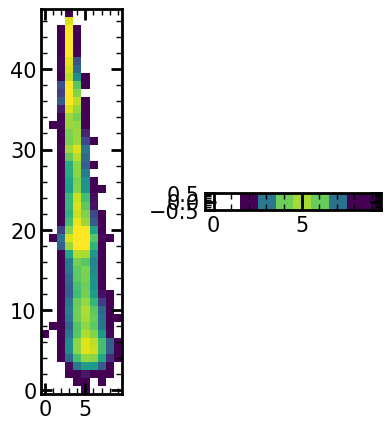

In [129]:
figure , axs = plt.subplots(1,2,figsize=[5,5])

label_muon = n_label
label_line = 10
muon = list_datamask[label_muon]
print('Numper of rows: ', muon.shape[0])
line = list_datamask[label_muon][label_line - 1:label_line][0]

n_longline = 0
for pixel in line:
    if pixel != 0:
        # print(pixel)
        n_longline += 1

print('Long of line: ', n_longline)

axs[0].imshow(list_datamask[label_muon], norm = Norm)
axs[1].imshow(list_datamask[label_muon][label_line - 1:label_line], norm = Norm)
plt.show()

In [204]:
list_index_long_muons = []
extension = 1

for index in range(0, len(list_newmatrix)):
    size_x = list_newmatrix[index].shape[1]
    size_y = list_newmatrix[index].shape[0]
    if size_y > 50:
        # print(size_x, size_y)
        list_index_long_muons.append(list_indexs[index])

# print(list_index_long_muons)+
print('Muones largos detectados: ', len(list_index_long_muons))
print('Indices: ', list_index_long_muons)

Muones largos detectados:  83
Indices:  [68, 189, 282, 396, 398, 415, 440, 572, 782, 969, 996, 1042, 1095, 1275, 1285, 1609, 1788, 1967, 2343, 2354, 2510, 2776, 2825, 2904, 2961, 2985, 3037, 3069, 3158, 3197, 3241, 3254, 3271, 3577, 3594, 3885, 3940, 3944, 3955, 3983, 4298, 4521, 4769, 5124, 5207, 5398, 5413, 5414, 5504, 5649, 5964, 6131, 6246, 6275, 6313, 6409, 6435, 6494, 6502, 6764, 6872, 6897, 6914, 7088, 7115, 7182, 7229, 7312, 7323, 7488, 7587, 7628, 7776, 7859, 7874, 7893, 7975, 7984, 8194, 8216, 8503, 8513, 8533]


#### Perfil Energético

54.55481005630669
Number of rows:  26


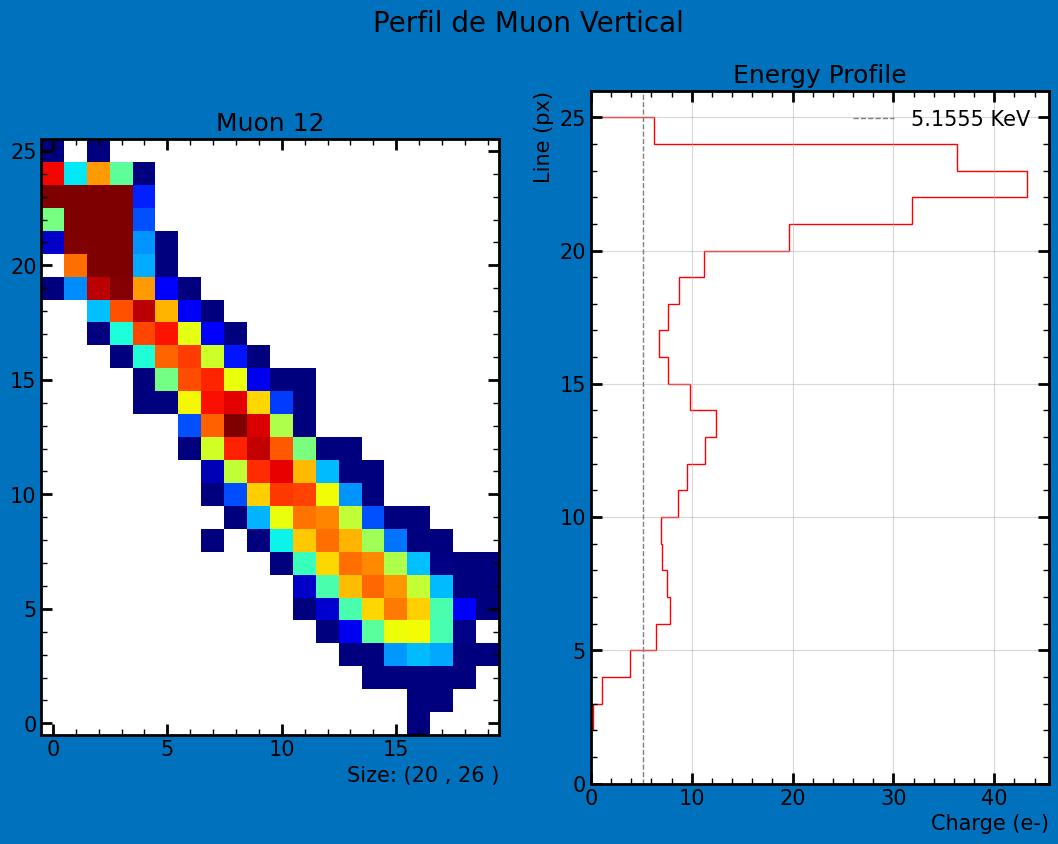

In [19]:
# list_muonlabels = [10, 15, 74, 91, 92, 112, 133, 176, 196, 256]  # Segunda revisión (están arriba)
muon_label = 12  # Se coloca directamente el label del evento
thet = DF_muons.iloc[[n_label]]['Theta (Deg)'].values[0]
print(thet)

Delta_inicial = 0
Delta_final = 0
extension = 1

fig, axs = plt.subplots(ncols=2, nrows=1, figsize = [13,9], facecolor = [0, 0.4470, 0.7410])
fig.suptitle('Perfil de Muon Vertical', y = 0.97, size = 20)
event = list_datamask[muon_label]
# plt.imshow(event)

size_x = event.shape[1] # tamaño en x
size_y = event.shape[0] # tamaño en y
# print(event.sum())

print('Number of rows: ', event.shape[0])
charge_verticalMuon = []
for index in range(1, size_y):
    line = event[index - 1:index][0]
    charge = line.sum()
    charge_verticalMuon.append(charge)

        
# cmap = 'plasma'
axs[0].imshow(event, cmap = ColorMap, norm = Norm)#, origin='upper')
axs[0].set_title('Muon ' + str(muon_label))
axs[0].set_xlabel('Size: (' + str(size_x) + ' , ' + str(size_y) + ' )')
# x0bar = fig.colorbar(x0, ax=axs[0])

en_cor = 4.2 /np.sin(np.radians(thet))
axs[1].stairs(charge_verticalMuon, range(0,len(charge_verticalMuon)+1),  orientation='horizontal', color = 'r')#,  hatch = '////')
axs[1].axvline(en_cor, 0, size_y+2, linestyle='--', color='gray', label = str(np.around(en_cor, 4)) +' KeV')
# axs[1].vlines(x = mean_charge, ymin = 0, ymax = len(event) - 1, color = 'k', label = 'Mean Charge \n' + str(mean_charge))

axs[1].set_ylim(0, size_y)
# axs[1].set_xlim(0, 4000)


# axs[1].set_xlabel('Charge (KeV)')
axs[1].set_xlabel('Charge (e-)')
axs[1].set_ylabel('Line (px)')
# axs[1].set_ylim(0,len(event) - 1 )
axs[1].set_title('Energy Profile')
axs[1].legend()
axs[1].grid()
plt.show()

#### Modelo de Difusión

In [219]:
CCD_depth = 675 # micras
Delta_inicial = 3    # px
Delta_final = 6     # px
Bins = 50

extension = 1
label_muon = 19
lable_line = 12
img_sigma = 0.0003  # KeV 
# print(img_sigma)

## Se checa si el muon tiene la orientación correcta
event = list_datamask[label_muon]
size_x = event.shape[1]
size_y = event.shape[0]

# lines = 0
Longitud_XY = size_y 
Longitud_linea = size_x

Z_inicial = (Delta_inicial * CCD_depth) / (Longitud_XY - Delta_final)


line = event[lable_line - 1:lable_line][0]
Carga_renglon = line.sum()
Mean_carga = np.mean(line)


Mean_in  = 0
var = 0
carga_cuadrada = 0

### Se calcula el X promedio ##
for pixel in np.arange(0, Longitud_linea, 1):
    if line[pixel]:
        element_pixel = (pixel * line[pixel]) / Carga_renglon
        Mean_in = Mean_in + element_pixel
    else:
        element_pixel = 0
    
    Mean_in = Mean_in + element_pixel

## Calcula la suma de las cargas al cuadrado ##
for pixel in np.arange(0, Longitud_linea, 1):
    if line[pixel]:
        element_pixel = line[pixel]**2
    else:
        element_pixel = 0

    carga_cuadrada = carga_cuadrada + element_pixel 

Mean_carga_cuadrada = carga_cuadrada/Longitud_linea

### Se calcula la varianza ##
for pixel in np.arange(0, Longitud_linea, 1):
    element_pixel =(1 / (Longitud_linea - 1)) * (pixel - Mean_in)**2
    var = var + element_pixel  ### COreggir la varianza con otro estimados

### Se corrige la varianza con la carga ###
var_true = var * (Mean_carga_cuadrada / (Mean_carga**2))

### Se calcula la sigma ###
sigma_in = np.sqrt(var)
# sigma_in = np.sqrt(var_true)


##Se crea un arreglo para usarlo en el plot de los datos, y se realiza el juste ##
list_xlabel = np.arange(0.5, len(line), 1)

# list_xlabel_long = np.linspace(-Longitud_linea + int(Longitud_linea/2) , Longitud_linea + int(Longitud_linea/2), Longitud_linea)

# popt, pcov = curve_fit(gaussian, list_xlabel, data_mask[0], maxfev=100000, p0 = [8000, Mean_in, sigma_in])		# Fit histogram with gaussian

print('Lonitud de la linea: ', len(line.flatten()))

## Ajuste gaussiano con ROOT ##
fgaus2 = TF1("fgauss","gaus",  0,  len(line.flatten()), 3) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
h3=TH1F("histogram", "Distribution of Line", len(line.flatten()) + 1, 0,  len(line.flatten()) )

for index in range(0, len(line)):
    if line[index] != 0:
        # print(index, line[index])
        h3.SetBinContent( index + 1, line[index])
        h3.SetBinError(index + 1, img_sigma)
        # h3.SetBinError(index + 1, 0.001)
        #print(pixel_value)

fgaus2.SetParameters(np.max(line),Mean_in,sigma_in) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
h3.Fit(fgaus2, "RQN")

fit_const = fgaus2.GetParameters()[0]
fit_mean = fgaus2.GetParameters()[1]
fit_sigma = fgaus2.GetParameters()[2]
print('Sigma fit: ', fit_sigma, end='\n\n')

c3=TCanvas()

h3.Draw()
c3.Draw()
fgaus2.Draw("same")
# gStyle.SetOptFit(1100)
# gStyle.SetPadGridX (True)



# plt.show()

Lonitud de la linea:  9
Sigma fit:  0.4237280227257192



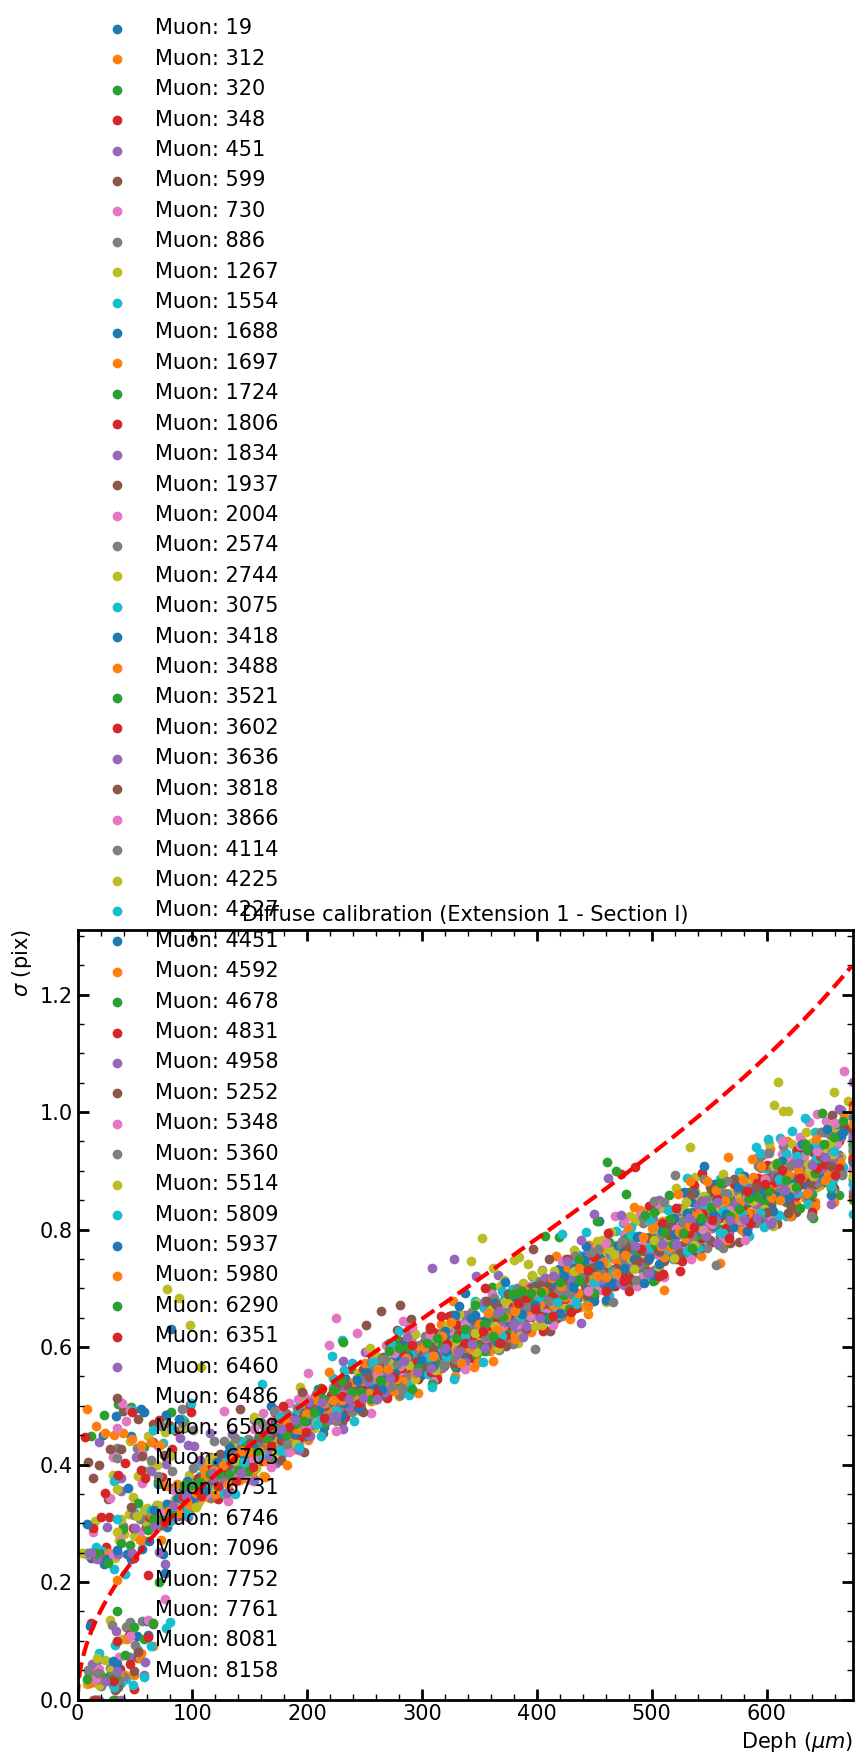

In [229]:
CCD_depth = 675 # micras
Bins = 50

extension = 1
label_muon = 1
img_sigma = 0.0008  # KeV 
# print(img_sigma)
fig, axs_all = plt.subplots(figsize = [10,10])

# Data 85 to 95 deg
# [7761, 7935, 8081, 8119, 8158, 8217, 8221, 8287, 8405]


# Data 265 to 275 
# [3577, 3594, 3885, 3940, 3944, 3955, 3983, 4298, 4521, 4769, 5124, 5207, 5398, 5413, 5414, 5504, 5649, 5964, 6131, 6246, 6275, 6313, 6409, 6435, 6494, 6502, 6764, 6872, 6897, 6914, 7088, 7115, 7182, 7229, 7312, 7323, 7488, 7587, 7628, 7776, 7859, 7874, 7893, 7975, 7984, 8194, 8216, 8503, 8513, 8533]



# ??????? Verticales 90°
# [19, 312, 320, 348, 599, 730, 1554, 1851, 2022, 2574, 2613, 2744, 2752, 3319, 3488, 3866, 4114, 4831, 4958, 5360, 5937, 5980, 6290, 6486, 6703, 7096, 7752, 7935, 8217]

# [68, 189, 282, 396, 415, 572, 782, 1095, 1285, 1967, 2510]

list_muonlabels0 = [19, 312, 320, 348, 451, 599, 730, 886, 1267, 1554, 1688, 1697, 1724, 1806, 1834, 1937, 2004, 2574, 2744, 3075, 3418, 3488, 3521, 3602, 
                    3636, 3818, 3866, 4114, 4225, 4227, 4451, 4592, 4678, 4831, 4958, 5252, 5348, 5360, 5514, 5809, 5937, 5980, 6290, 6351, 6460, 6486, 6508,
                    6703, 6731, 6746, 7096, 7752, 7761, 8081, 8158]


list_muonlabels1 = [68, 189, 282, 396, 2904, 3037, 3069, 3158]

# list_muonlabels = list_muonlabels0 + list_muonlabels1
list_muonlabels = list_muonlabels0


for label_muon in list_muonlabels: 
    Delta_inicial = 1    # px
    Delta_final = 5     # px
    event = list_datamask[label_muon]
    size_x = event.shape[1]
    size_y = event.shape[0]

    # lines = 0
    Longitud_XY = size_y 
    Z_inicial = (Delta_inicial * CCD_depth) / (Longitud_XY - Delta_final)
    # print('Muon: ', label_muon, ', Shape (X, Y): ', event.shape[1], event.shape[0])

    list_fitsigmas = []
    if label_muon in list_muonlabels1:
        Delta_inicial = Delta_final
        Delta_final = Delta_inicial


    for lable_line in range(Delta_inicial, size_y - Delta_final):
        line = event[lable_line - 1:lable_line][0]
        Carga_renglon = line.sum()
        Mean_carga = np.mean(line)
        Longitud_linea = len(line)


        Mean_in  = 0
        var = 0
        carga_cuadrada = 0

        ### Se calcula el X promedio ##
        for pixel in range(0, Longitud_linea):
            if line[pixel]:
                element_pixel = (pixel * line[pixel]) / Carga_renglon
                Mean_in = Mean_in + element_pixel
            else:
                element_pixel = 0
            
            Mean_in = Mean_in + element_pixel

        ## Calcula la suma de las cargas al cuadrado ##
        for pixel in np.arange(0, Longitud_linea, 1):
            if line[pixel]:
                element_pixel = line[pixel]**2
            else:
                element_pixel = 0

            carga_cuadrada = carga_cuadrada + element_pixel 

        Mean_carga_cuadrada = carga_cuadrada/Longitud_linea

        ### Se calcula la varianza ##
        for pixel in np.arange(0, Longitud_linea, 1):
            if line[pixel]:
                element_pixel =(1 / (Longitud_linea - 1)) * (pixel - Mean_in)**2 * line[pixel]
                var = var + element_pixel  ### COreggir la varianza con otro estimados

        ### Se corrige la varianza con la carga ###
        # var_true = var * (Mean_carga_cuadrada / (Mean_carga**2))
        var_true = var / Carga_renglon

        ### Se calcula la sigma ###
        sigma_in = np.sqrt(var_true)
        # print(sigma_in)
        # sigma_in = np.sqrt(var_true)


        ##Se crea un arreglo para usarlo en el plot de los datos, y se realiza el juste ##
        list_xlabel = np.arange(0.5, len(line), 1)


        ## Ajuste gaussiano con ROOT ##
        fgaus2 = TF1("fgauss","gaus",  0,  len(line.flatten()), 3) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
        h3=TH1F("histogram", "Distribution of Line", len(line.flatten()) + 1, 0,  len(line.flatten()) )

        for index in range(0, len(line)):
            if line[index] != 0:
                # print(index, line[index])
                h3.SetBinContent( index + 1, line[index])
                h3.SetBinError(index + 1, img_sigma)
                # h3.SetBinError(index + 1, 0.001)
                #print(pixel_value)

        fgaus2.SetParameters(np.max(line),Mean_in,sigma_in) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
        h3.Fit(fgaus2, "RQN")

        fit_const = fgaus2.GetParameters()[0]
        fit_mean = fgaus2.GetParameters()[1]
        fit_sigma = fgaus2.GetParameters()[2]


        # fit_sigma = sigma_in
        # print('Sigma fit: ', fit_sigma)
        list_fitsigmas.append(fit_sigma)

        del h3

    list_deep = []
    list_xlabel_sigmas = np.linspace(Z_inicial, CCD_depth, len(list_fitsigmas))
    for deep in list_xlabel_sigmas:
        list_deep.append(deep)

    if label_muon in list_muonlabels1:
        # print('Gola', list_fitsigmas[0], list_fitsigmas[-1])
        list_fitsigmas.reverse()
        # print('Agios', list_fitsigmas[0], list_fitsigmas[-1], end='\n\n')

    axs_all.scatter(list_deep, list_fitsigmas, label = 'Muon: ' + str(label_muon))
    # axs_all.scatter(list_deep, list_fitsigmas)


def diffution_curve(z, alpha, beta):
    return np.sqrt((alpha * np.log(1 - (beta * z))))

fit_range = np.arange(0, 675)
Label = r'$\sqrt{\alpha \ln(1 - \beta z)}$ fit $\alpha$:' + str(np.around(fit_alpha, 1)) + r' $\mu m^{2}$, $\beta$: ' + str(np.around(fit_beta, 6)) + r' $\mu m^{-1}$'

axs_all.plot(fit_range, diffution_curve(fit_range, alpha=-211.9, beta=0.0012) / 15, '--r', linewidth = 3)
# axs_all.plot(fit_range, diffution_curve(fit_range, alpha=fit_alpha, beta=fit_beta)/15, '--k', linewidth = 3, label= Label)
# axs_all.plot(fit_range, diffution_curve(fit_range, alpha=-292.4325743170209, beta=3.990904646095944e-06), '--c', linewidth = 2, label='Fit CONNIE')

axs_all.set_title('Diffuse calibration (Extension 1 - Section I)', size = 15)#, y=0.92)}
axs_all.set_ylabel(r'$\sigma$ (pix)')
axs_all.set_xlabel(r'Deph ($\mu m$)')
axs_all.set_ylim(0, )
axs_all.set_xlim(0, 675)
axs_all.legend()
axs_all.grid
plt.show()

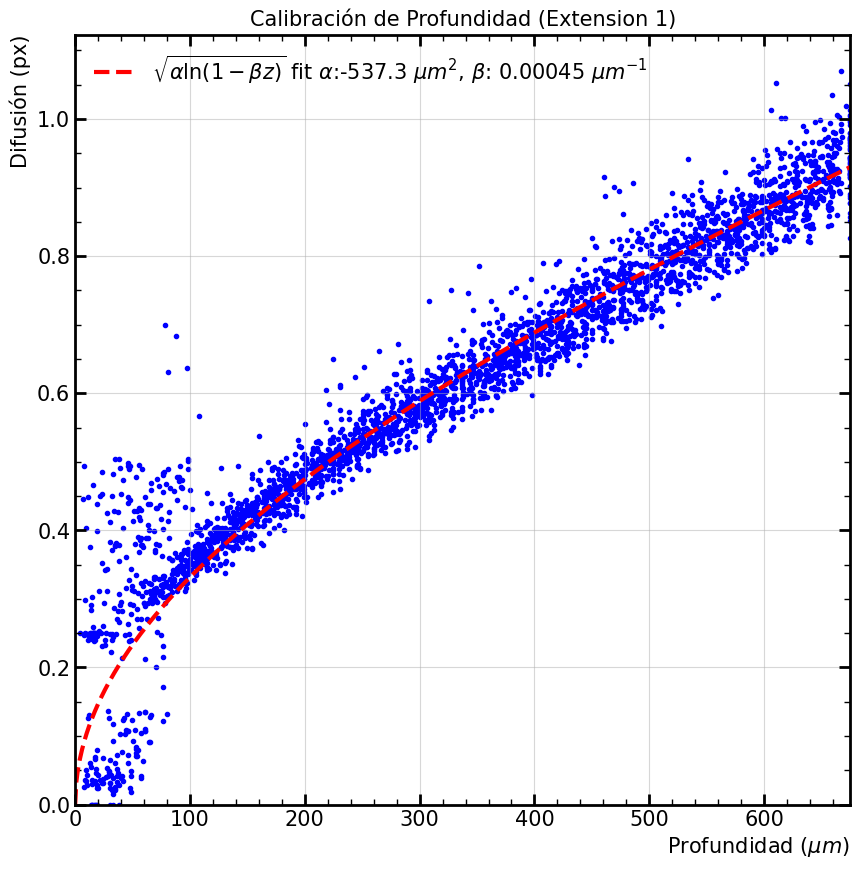

In [230]:
img_sigma = 0.0008  # KeV 
# print(img_sigma)
fig, axs_all = plt.subplots(figsize = [10,10])

# list_muonlabels = [256, 257, 258]

list_all_sigmas = []
list_all_deeps = []

for label_muon in list_muonlabels: 
    Delta_inicial = 1    # px
    Delta_final = 5     # px
    event = list_datamask[label_muon]
    size_x = event.shape[1]
    size_y = event.shape[0]

    # lines = 0
    Longitud_XY = size_y 
    Z_inicial = (Delta_inicial * CCD_depth) / (Longitud_XY - Delta_final)
    # print('Muon: ', label_muon, ', Shape (X, Y): ', event.shape[1], event.shape[0])

    list_fitsigmas = []
    if label_muon in list_muonlabels1:
        Delta_inicial = Delta_final
        Delta_final = Delta_inicial

    for lable_line in range(Delta_inicial, size_y - Delta_final):
        line = event[lable_line - 1:lable_line][0]
        Carga_renglon = line.sum()
        Mean_carga = np.mean(line)
        Longitud_linea = len(line)


        Mean_in  = 0
        var = 0
        carga_cuadrada = 0

        ### Se calcula el X promedio ##
        for pixel in range(0, Longitud_linea):
            if line[pixel]:
                element_pixel = (pixel * line[pixel]) / Carga_renglon
                Mean_in = Mean_in + element_pixel
            else:
                element_pixel = 0
            
            Mean_in = Mean_in + element_pixel

        ## Calcula la suma de las cargas al cuadrado ##
        for pixel in np.arange(0, Longitud_linea, 1):
            if line[pixel]:
                element_pixel = line[pixel]**2
            else:
                element_pixel = 0

            carga_cuadrada = carga_cuadrada + element_pixel 

        Mean_carga_cuadrada = carga_cuadrada/Longitud_linea

        ### Se calcula la varianza ##
        for pixel in np.arange(0, Longitud_linea, 1):
            if line[pixel]:
                element_pixel =(1 / (Longitud_linea - 1)) * (pixel - Mean_in)**2 * line[pixel]
                var = var + element_pixel  ### COreggir la varianza con otro estimados

        ### Se corrige la varianza con la carga ###
        # var_true = var * (Mean_carga_cuadrada / (Mean_carga**2))
        var_true = var / Carga_renglon

        ### Se calcula la sigma ###
        sigma_in = np.sqrt(var)
        # print(sigma_in)
        # sigma_in = np.sqrt(var_true)


        ##Se crea un arreglo para usarlo en el plot de los datos, y se realiza el juste ##
        list_xlabel = np.arange(0.5, len(line), 1)


        ## Ajuste gaussiano con ROOT ##
        fgaus2 = TF1("fgauss","gaus",  0,  len(line.flatten()), 3) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
        h3=TH1F("histogram", "Distribution of Line", len(line.flatten()) + 1, 0,  len(line.flatten()) )

        for index in range(0, len(line)):
            if line[index] != 0:
                # print(index, line[index])
                h3.SetBinContent( index + 1, line[index])
                h3.SetBinError(index + 1, img_sigma)
                # h3.SetBinError(index + 1, 0.001)
                #print(pixel_value)

        fgaus2.SetParameters(np.max(line),Mean_in,sigma_in) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
        h3.Fit(fgaus2, "RQN")

        fit_const = fgaus2.GetParameters()[0]
        fit_mean = fgaus2.GetParameters()[1]
        fit_sigma = fgaus2.GetParameters()[2]


        # fit_sigma = sigma_in
        # print('Sigma fit: ', fit_sigma)
        list_fitsigmas.append(fit_sigma)

        del h3

    list_deep = []
    list_xlabel_sigmas = np.linspace(Z_inicial, CCD_depth, len(list_fitsigmas))
    for deep in list_xlabel_sigmas:
        list_deep.append(deep)

    if label_muon in list_muonlabels1:
        # print('Gola', list_fitsigmas[0], list_fitsigmas[-1])
        list_fitsigmas.reverse()
        # print('Agios', list_fitsigmas[0], list_fitsigmas[-1], end='\n\n')
        
    for index in range(0, len(list_fitsigmas)):
        list_all_sigmas.append(list_fitsigmas[index])
        list_all_deeps.append(list_deep[index])

    # axs_all.scatter(list_deep, list_fitsigmas, marker='2', label = 'Muon: ' + str(label_muon))
del list_fitsigmas
del list_deep


fit_range = np.arange(0, 725)



axs_all.scatter(list_all_deeps, list_all_sigmas, marker='.', facecolor = 'b')

def diffution_curve(x, alpha, beta):
    return np.sqrt((alpha * np.log(1 - (beta * x))))

# popt_DM, _ = curve_fit(diffution_curve, list_all_deeps, list_all_sigmas, maxfev=100000, p0= [1, 1])
# dict_diffution_model = {'Alpha' : popt_DM[0], 'Beta' : popt_DM[1]}
# print('Alpha: ', dict_diffution_model['Alpha'], ' Beta: ', dict_diffution_model['Beta'])



axs_all.plot(fit_range, diffution_curve(fit_range, alpha=fit_alpha, beta=fit_beta)/15, '--r', linewidth = 3, label= Label)
# axs_all.plot(fit_range, diffution_curve(fit_range, -611, 0.00045)/15, '--r', linewidth = 3)

axs_all.set_title('Calibración de Profundidad (Extension 1)', size = 15)#, y=0.92)}
axs_all.set_ylabel(r'Difusión (px)')
axs_all.set_xlabel(r'Profundidad ($\mu m$)')
axs_all.set_ylim(0,)
axs_all.set_xlim(0, 675)
axs_all.legend()
axs_all.grid()
plt.show()

In [231]:
list_all_sigmas = []
list_all_deeps = []

for label_muon in list_muonlabels: 
    Delta_inicial = 1    # px
    Delta_final = 5     # px
    event = list_datamask[label_muon]
    size_x = event.shape[1]
    size_y = event.shape[0]

    # lines = 0
    Longitud_XY = size_y 
    Z_inicial = (Delta_inicial * CCD_depth) / (Longitud_XY - Delta_final)
    # print('Muon: ', label_muon, ', Shape (X, Y): ', event.shape[1], event.shape[0])

    list_fitsigmas = []
    if label_muon in list_muonlabels1:
        Delta_inicial = Delta_final
        Delta_final = Delta_inicial

    for lable_line in range(Delta_inicial, size_y - Delta_final):
        line = event[lable_line - 1:lable_line][0]
        Carga_renglon = line.sum()
        Mean_carga = np.mean(line)
        Longitud_linea = len(line)


        Mean_in  = 0
        var = 0
        carga_cuadrada = 0

        ### Se calcula el X promedio ##
        for pixel in range(0, Longitud_linea):
            if line[pixel]:
                element_pixel = (pixel * line[pixel]) / Carga_renglon
                Mean_in = Mean_in + element_pixel
            else:
                element_pixel = 0
            
            Mean_in = Mean_in + element_pixel

        ## Calcula la suma de las cargas al cuadrado ##
        for pixel in np.arange(0, Longitud_linea, 1):
            if line[pixel]:
                element_pixel = line[pixel]**2
            else:
                element_pixel = 0

            carga_cuadrada = carga_cuadrada + element_pixel 

        Mean_carga_cuadrada = carga_cuadrada/Longitud_linea

        ### Se calcula la varianza ##
        for pixel in np.arange(0, Longitud_linea, 1):
            if line[pixel]:
                element_pixel =(1 / (Longitud_linea - 1)) * (pixel - Mean_in)**2 * line[pixel]
                var = var + element_pixel  ### COreggir la varianza con otro estimados

        ### Se corrige la varianza con la carga ###
        # var_true = var * (Mean_carga_cuadrada / (Mean_carga**2))
        var_true = var / Carga_renglon

        ### Se calcula la sigma ###
        sigma_in = np.sqrt(var)
        # print(sigma_in)
        # sigma_in = np.sqrt(var_true)


        ##Se crea un arreglo para usarlo en el plot de los datos, y se realiza el juste ##
        list_xlabel = np.arange(0.5, len(line), 1)


        ## Ajuste gaussiano con ROOT ##
        fgaus2 = TF1("fgauss","gaus",  0,  len(line.flatten()), 3) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
        h3=TH1F("histogram", "Distribution of Line", len(line.flatten()) + 1, 0,  len(line.flatten()) )

        for index in range(0, len(line)):
            if line[index] != 0:
                # print(index, line[index])
                h3.SetBinContent( index + 1, line[index])
                h3.SetBinError(index + 1, img_sigma)
                # h3.SetBinError(index + 1, 0.001)
                #print(pixel_value)

        fgaus2.SetParameters(np.max(line),Mean_in,sigma_in) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
        h3.Fit(fgaus2, "RQN")

        fit_const = fgaus2.GetParameters()[0]
        fit_mean = fgaus2.GetParameters()[1]
        fit_sigma = fgaus2.GetParameters()[2]


        # fit_sigma = sigma_in
        # print('Sigma fit: ', fit_sigma)
        list_fitsigmas.append(fit_sigma)

        del h3

    list_deep = []
    list_xlabel_sigmas = np.linspace(Z_inicial, CCD_depth, len(list_fitsigmas))
    for deep in list_xlabel_sigmas:
        list_deep.append(deep)

    if label_muon in list_muonlabels1:
        # print('Gola', list_fitsigmas[0], list_fitsigmas[-1])
        list_fitsigmas.reverse()
        # print('Agios', list_fitsigmas[0], list_fitsigmas[-1], end='\n\n')

    for index in range(0, len(list_fitsigmas)):
        list_all_sigmas.append(list_fitsigmas[index])
        list_all_deeps.append(list_deep[index])

    # axs_all.scatter(list_deep, list_fitsigmas, marker='2', label = 'Muon: ' + str(label_muon))
del list_fitsigmas
del list_deep



# fit_range = np.arange(0, 900)
# axs_all.scatter(list_all_deeps, list_all_sigmas, marker='2')
 
h_model = TGraph(len(list_all_sigmas), np.array(list_all_deeps),np.array(list_all_sigmas))
h_model.SetMarkerStyle(2) # Set marker style (e.g., solid circle)
h_model.SetTitle("Modelo de dif. (Extensión 1- Muones Verticales)")
h_model.GetXaxis().SetTitle("Profundidad (micras)")
h_model.GetYaxis().SetTitle("Anchura (micras)")
h_model.SetStats(0)
h_model.GetXaxis().SetRangeUser(0, 725)
h_model.GetYaxis().SetRangeUser(0, 1.4)



Range_fit = [100, 675]
diff_curve = TF1("diff_curve", "sqrt(([0] * log(1 - [1]*x)))/15", Range_fit[0], Range_fit[1], 2) #np.sqrt(np.abs(alpha * np.log(1 - (beta * z))))

diff_curve.SetParameters(-200, 0.00001) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
h_model.Fit(diff_curve, "RNQ")

fit_alpha = diff_curve.GetParameters()[0]
fit_beta = diff_curve.GetParameters()[1]
chi2 = diff_curve.GetChisquare()
ndf = diff_curve.GetNDF()
prob = diff_curve.GetProb()

fit_alpha_err = diff_curve.GetParErrors()[0]
fit_beta_err = diff_curve.GetParErrors()[1]

print('Alpha: ', fit_alpha, '+- ', fit_alpha_err) 
print('Beta: ', fit_beta,  '+- ', fit_beta_err)
print('Chi2/ndf: ', chi2, '/', ndf)
print('Prob: ', prob)

c3=TCanvas("","", 1000, 600)
h_model.Draw("AP same")
diff_curve.Draw("same")
c3.Draw()

leg = TLegend(0.1,0.7,0.48,0.9)
leg.AddEntry(diff_curve, r"\sqrt{\alpha \log(1 - \beta z)} fit: \alpha= " + str(np.around(fit_alpha, 3)) + r" \mu m^2, \beta= " + str(np.around(fit_beta, 6)) + " \mu m^{-1}", "L")
leg.Draw()

Alpha:  -537.2992980538203 +-  25.547588685701186
Beta:  0.0004500970706628087 +-  1.8889167008270262e-05
Chi2/ndf:  3.0285952593283407 / 2544
Prob:  1.0


In [234]:
from array import array

spread_array = array('f', [-9999])
deep_array = array('f', [-9999])

location_file = './'
file_root_name = 'tree_DiffusionMod_Vert_90deg.root'
file = TFile.Open(location_file  + file_root_name, "RECREATE")
tree = TTree('tree', 'tree')

tree.Branch('sprd', spread_array, 'sprd/F')
tree.Branch('deep', deep_array, 'deep/F')

for i in range(0, len(list_all_sigmas)):
    spread_array[0] = list_all_sigmas[i]
    deep_array[0] = list_all_deeps[i]
    
    tree.Fill()

tree.Write()
file.Close()

### Muones horizontales

#### DataFrame y visualización

In [19]:
### Se crea el dataframe y se selecciona un rango de datos ###
Ext = 1
DF_muons, list_datamask = DataFrame_muons(data_histogram, extension=Ext)
# display(DF_muons[450:500])
list_newmatrix = []
list_indexs =[]
#
# range_in_phi = DF_muons[DF_muons['Phi (Deg)'].between(0, 5)]    # Horizontales derecha
# range_in_phi = DF_muons[DF_muons['Phi (Deg)'].between(355, 360)]
range_in_phi = DF_muons[DF_muons['Phi (Deg)'].between(175, 185)]

for index in range_in_phi.index:
    # print(index)
    list_newmatrix.append(list_datamask[index])
    list_indexs.append(index)

print(list_indexs)
list_phi_ext1 = data_histogram['extension_' + str(Ext)]['phi']
list_mask_rot = []

list_listsnxny = []

for index in list_indexs[:]:
    datamask = list_datamask[index]
    ylen, xlen = datamask.shape
    list_nxny = []

    data_mask_zeros = np.empty((ylen + 90, xlen+50))
    data_mask_zeros[:] = 0
    ylen_zeros, xlen_zeros = data_mask_zeros.shape
    # print(data_mask_zeros.shape)
    
    ### Angle rot ##
    phi_rot = np.pi/2 - list_phi_ext1[index]
    # print(phi_rot, phi_rot + list_phi_ext1[index])

    # print('shape original: ', xlen, ylen)
    # print('shape zeros: ', xlen_zeros, ylen_zeros)

    # for y_bin in range(0, ylen):
    #     for x_bin in range(0, xlen):
    #         if datamask[y_bin][x_bin] != 0:
    #             nx, ny = pixel_rot(x_bin=x_bin, x0=0, y_bin=y_bin, y0=0, theta= phi_rot)
    #             list_nxny.append((nx + 200, ny))
    #             # print(nx, ny)
    #             data_mask_zeros[ny][nx+200] = datamask[y_bin][x_bin]

    # list_listsnxny.append(list_nxny)
    # label_img, nlabels_img = sk.measure.label(data_mask_zeros > 0, connectivity=2, return_num=True)
    # loc = nd.find_objects(label_img == 1)[0]
    # mask_rot = np.invert(label_img==1)
    # # data_mask_rot = ma.masked_array(data_mask_zeros, mask_rot)
    # data_mask_rot = ma.masked_array(data_mask_zeros[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_rot[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])

    # list_mask_rot.append(data_mask_rot)
    # print('Shape rot: ', data_mask_rot.shape[1], data_mask_rot.shape[0])
    
    # plt.imshow(data_mask_rot)
    # plt.show()

# print(list_mask_rot)
#     

[1, 16, 34, 37, 54, 64, 162, 293, 317, 330, 333, 343, 347, 371, 415, 416, 456, 486, 493, 501, 507, 534, 545, 574, 577, 584, 594, 609, 617, 626, 701, 707, 716, 723, 726, 736, 745, 756, 759, 773, 775, 816, 819, 828, 832, 847, 867, 878, 885, 898, 914, 933, 937, 941, 946, 949, 961, 982, 993, 995, 997, 1002, 1016, 1021, 1022, 1023, 1025, 1030, 1041, 1044, 1047, 1048, 1054, 1085, 1087, 1123, 1125]


,date_run,Gain (ADU/e-),Solidity,Elipticity,Theta (Deg),Phi (Deg),Charge (KeV),l (cm),dEdL (KeV/cm)
Muon ID,,,,,,,,,
73,ENE2024,230.615822,0.8,0.760989,30.0812,358.381275,205.3815,0.083784,2451.30875


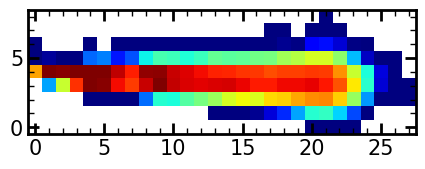

In [20]:
n_label = 73
display(DF_muons.iloc[[n_label]])

figure , axs = plt.subplots(1,1,figsize=[5,5])
# axs.imshow(list_mask_rot[n_label],  cmap = ColorMap, norm=Norm)  
axs.imshow(list_datamask[n_label],  cmap = ColorMap, norm=Norm)
plt.show()


Numper of rows:  9
Long of line:  5


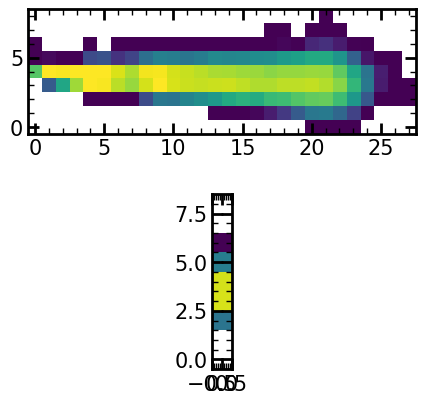

In [21]:
figure , axs = plt.subplots(2,1,figsize=[5,5])

label_muon = n_label
label_line = 10
muon = list_datamask[label_muon]
print('Numper of rows: ', muon.shape[0])
line = muon[:, label_line: label_line + 1]
# line = list_mask_rot[label_muon][label_line - 1:label_line][0]

n_longline = 0
for pixel in line:
    if pixel[0] != 0:
        # print(pixel)
        n_longline += 1

print('Long of line: ', n_longline)

# axs[0].imshow(list_mask_rot[label_muon], norm = Norm)
# axs[1].imshow(list_mask_rot[label_muon][label_line - 1:label_line], norm = Norm)

axs[0].imshow(muon, norm = Norm)
axs[1].imshow(muon[:, label_line: label_line + 1], norm = Norm)
plt.show()

In [22]:
list_index_long_muons = []
extension = 1

for index in range(0, len(list_datamask)):
    size_x = list_datamask[index].shape[1]
    # size_y = list_datamask[index].shape[0]
    if size_x > 50:
        # print(size_x, size_y)
        list_index_long_muons.append(index)

# print(list_index_long_muons)+
print('Muones largos detectados: ', len(list_index_long_muons))
print('Indices: ', list_index_long_muons)

Muones largos detectados:  167
Indices:  [8, 10, 17, 21, 34, 35, 36, 46, 56, 57, 60, 61, 64, 65, 86, 98, 116, 129, 132, 142, 151, 175, 184, 193, 198, 213, 218, 219, 241, 257, 260, 264, 267, 275, 290, 291, 303, 304, 312, 322, 323, 330, 355, 379, 380, 381, 401, 415, 416, 429, 452, 464, 467, 469, 472, 474, 477, 485, 486, 491, 492, 503, 504, 508, 514, 522, 529, 533, 534, 535, 540, 556, 591, 592, 600, 606, 619, 630, 645, 648, 663, 665, 666, 668, 673, 679, 693, 695, 700, 704, 710, 721, 726, 727, 729, 741, 743, 745, 754, 756, 759, 773, 775, 783, 786, 788, 792, 806, 808, 813, 819, 826, 827, 830, 838, 857, 858, 881, 885, 888, 892, 897, 906, 908, 914, 916, 917, 918, 920, 921, 923, 936, 940, 945, 947, 948, 960, 965, 976, 977, 982, 985, 987, 994, 997, 999, 1003, 1012, 1018, 1023, 1030, 1031, 1032, 1044, 1047, 1050, 1054, 1064, 1074, 1080, 1087, 1102, 1111, 1112, 1114, 1128, 1137]


#### Perfil energético

30.081199799514426
Number of rows:  14


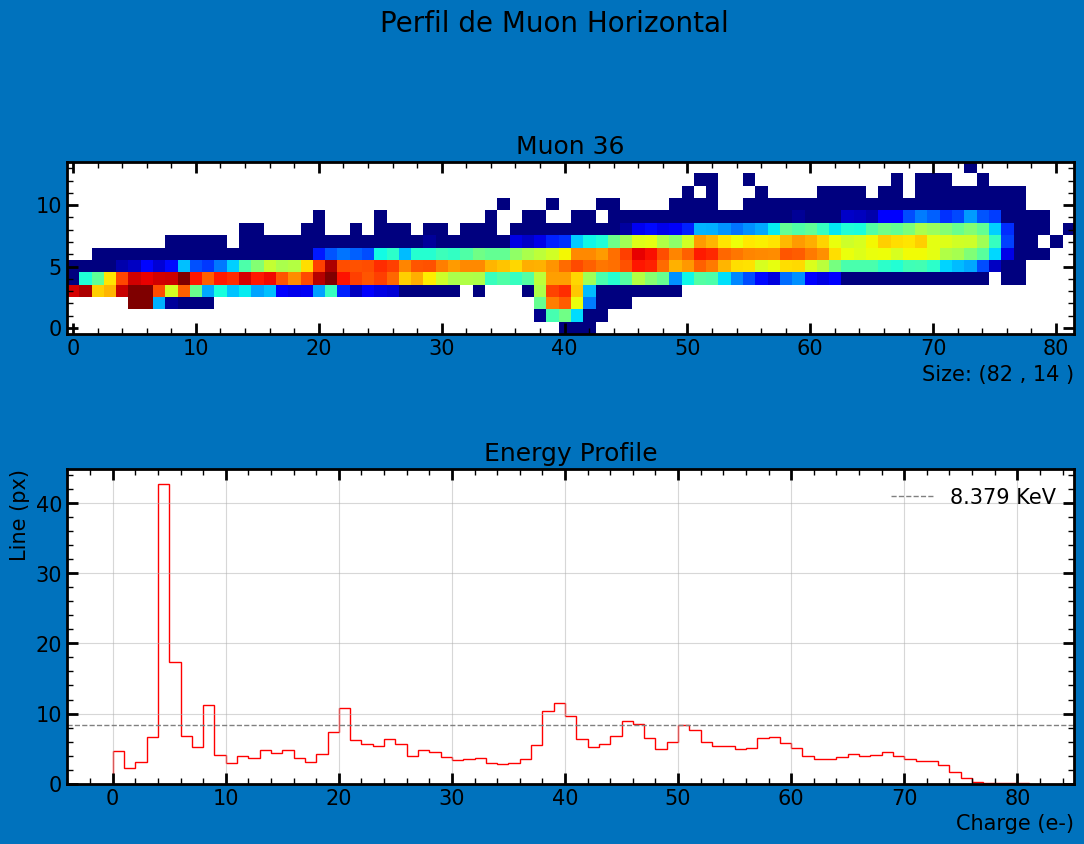

In [23]:
muon_label = 36  # Se coloca directamente el label del evento
thet = DF_muons.iloc[[n_label]]['Theta (Deg)'].values[0]
print(thet)

Delta_inicial = 0
Delta_final = 0
extension = 1

fig, axs = plt.subplots(ncols=1, nrows=2, figsize = [13,9], facecolor = [0, 0.4470, 0.7410])
fig.suptitle('Perfil de Muon Horizontal', y = 0.97, size = 20)
event = list_datamask[muon_label]
# plt.imshow(event)

size_x = event.shape[1] # tamaño en x
size_y = event.shape[0] # tamaño en y
# print(event.sum())

print('Number of rows: ', event.shape[0])
charge_horizontalMuon = []
for index in range(1, size_x):
    line = event[:, index: index + 1]
    charge = line.sum()
    charge_horizontalMuon.append(charge)

        
# cmap = 'plasma'
axs[0].imshow(event, cmap = ColorMap, norm = Norm)#, origin='upper')
axs[0].set_title('Muon ' + str(muon_label))
axs[0].set_xlabel('Size: (' + str(size_x) + ' , ' + str(size_y) + ' )')
# x0bar = fig.colorbar(x0, ax=axs[0])

en_cor = 4.2 /np.sin(np.radians(thet))
axs[1].stairs(charge_horizontalMuon, range(0,len(charge_horizontalMuon)+1),  orientation='vertical', color = 'r')#,  hatch = '////')
axs[1].axhline(en_cor, 0, size_x+2, linestyle='--', color='gray', label = str(np.around(en_cor, 3)) +  ' KeV')
# axs[1].vlines(x = mean_charge, ymin = 0, ymax = len(event) - 1, color = 'k', label = 'Mean Charge \n' + str(mean_charge))

# axs[1].set_ylim(0, size_x)
# axs[1].set_xlim(0, 4000)


# axs[1].set_xlabel('Charge (KeV)')
axs[1].set_xlabel('Charge (e-)')
axs[1].set_ylabel('Line (px)')
# axs[1].set_ylim(0,len(event) - 1 )
axs[1].set_title('Energy Profile')
axs[1].legend()
axs[1].grid()
plt.show()

#### Modelo Difusión

In [24]:
CCD_depth = 725 # micras
Delta_inicial = 3    # px
Delta_final = 6     # px
Bins = 50

extension = 1
label_muon = 36
lable_line = 12
img_sigma = 0.0003  # KeV 
# print(img_sigma)

## Se checa si el muon tiene la orientación correcta
event = list_datamask[label_muon]
size_x = event.shape[1]
size_y = event.shape[0]

# lines = 0
Longitud_XY = size_x 
Longitud_linea = size_y

Z_inicial = (Delta_inicial * CCD_depth) / (Longitud_XY - Delta_final)


line = event[:, lable_line: lable_line + 1]
Carga_renglon = line.sum()
Mean_carga = np.mean(line)
# print(Carga_renglon, Mean_carga, len(line))


Mean_in  = 0
var = 0
carga_cuadrada = 0

### Se calcula el X promedio ##
for pixel in range(0, Longitud_linea, 1):
    if line[pixel][0]:
        element_pixel = (pixel * line[pixel][0]) / Carga_renglon
        Mean_in = Mean_in + element_pixel
    else:
        element_pixel = 0
    
    Mean_in = Mean_in + element_pixel

## Calcula la suma de las cargas al cuadrado ##
for pixel in range(0, Longitud_linea, 1):
    if line[pixel][0]:
        # print(line[pixel])
        element_pixel = line[pixel][0]**2
    else:
        element_pixel = 0

    carga_cuadrada = carga_cuadrada + element_pixel 

Mean_carga_cuadrada = carga_cuadrada/Longitud_linea

### Se calcula la varianza ##
for pixel in range(0, Longitud_linea, 1):
    element_pixel =(1 / (Longitud_linea - 1)) * (pixel - Mean_in)**2
    var = var + element_pixel  ### COreggir la varianza con otro estimados

### Se corrige la varianza con la carga ###
var_true = var * (Mean_carga_cuadrada / (Mean_carga**2))

### Se calcula la sigma ###
sigma_in = np.sqrt(var)
# sigma_in = np.sqrt(var_true)


##Se crea un arreglo para usarlo en el plot de los datos, y se realiza el juste ##
list_xlabel = np.arange(0.5, len(line), 1)
print('Lonitud de la linea: ', len(line))

## Ajuste gaussiano con ROOT ##
fgaus2 = TF1("fgauss","gaus",  0,  len(line), 3) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
h3=TH1F("histogram", "Distribution of Line", len(line) + 1, 0,  len(line) )

for index in range(0, len(line)):
    if line[index][0] != 0:
        # print(index, line[index])
        h3.SetBinContent( index + 1, line[index][0])
        h3.SetBinError(index + 1, img_sigma)
        # h3.SetBinError(index + 1, 0.001)
        #print(pixel_value)

fgaus2.SetParameters(np.max(line),Mean_in,sigma_in) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
h3.Fit(fgaus2, "RQN")

fit_const = fgaus2.GetParameters()[0]
fit_mean = fgaus2.GetParameters()[1]
fit_sigma = fgaus2.GetParameters()[2]
print('Sigma fit: ', fit_sigma, end='\n\n')

c3=TCanvas()

h3.Draw()
c3.Draw()
fgaus2.Draw("same")

Lonitud de la linea:  14
Sigma fit:  0.4430840416489532



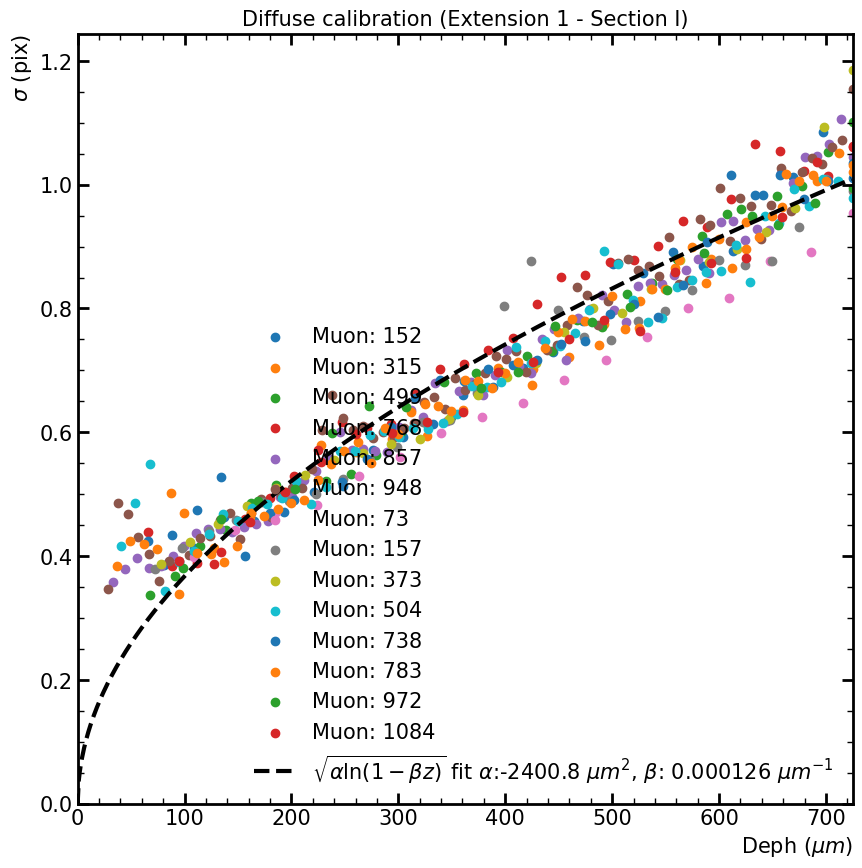

Warning in <TROOT::Append>: Replacing existing TH1: histogram (Potential memory leak).


In [25]:
CCD_depth = 725 # micras
Delta_inicial = 3    # px
Delta_final = 8     # px
Bins = 50

extension = 1
img_sigma = 0.0008  # KeV 
# print(img_sigma)
fig, axs_all = plt.subplots(figsize = [10,10])

# Data for phi between 0 to 5 deg
# [36, 57, 61, 152, 188, 254, 262, 265, 266, 271, 315, 316, 320, 348, 444, 454, 499, 500, 505, 573, 632, 637, 686, 703, 768, 771, 815, 818, 824, 836, 857, 909, 948, 956, 963]

# Data for phi between 355 to 360 deg
# [21, 73, 107, 110, 157, 199, 204, 280, 329, 373, 429, 448, 504, 587, 591, 604, 659, 738, 743, 758, 770, 783, 810, 841, 844, 855, 918, 920, 972, 974, 1014, 1061, 1084, 1114]

# Data for phi between 175 to 185 
# [1, 16, 34, 37, 54, 64, 162, 293, 317, 330, 333, 343, 347, 371, 415, 416, 456, 486, 493, 501, 507, 534, 545, 574, 577, 584, 594, 609, 617, 626, 701, 707, 716, 723, 726, 736, 
# 745, 756, 759, 773, 775, 816, 819, 828, 832, 847, 867, 878, 885, 898, 914, 933, 937, 941, 946, 949, 961, 982, 993, 995, 997, 1002, 1016, 1021, 1022, 1023, 1025, 1030, 1041, 
# 1044, 1047, 1048, 1054, 1085, 1087, 1123, 1125]

# list_muonlabels0 = [57, 152, 188, 254, 266, 315, 316, 499, 768, 836,  857, 948] # Phi 0 to 5 deg
# list_muonlabels1= [73, 110, 157, 204, 280, 329, 373, 448, 504, 738, 783,  844, 972, 1084, 1114] # Phi 355 to 360
# list_muonlabels2= [34, 54, 64, 330, 371, 416, 486, 773, 775, 819, 885, 914, 997, 1002, 1023, 1030, 1044] # Phi 175 to 185

list_muonlabels0 = [152, 315, 499, 768,  857, 948] # Phi 0 to 5 deg
list_muonlabels1= [73, 157, 373, 504, 738, 783, 972, 1084] # Phi 355 to 360
list_muonlabels2= [330, 371, 416, 486, 997, 1002, 1023] # Phi 175 to 185

# print(list_muonlabels0 +  list_muonlabels1)
# list_muonlabels = list_muonlabels0  +  list_muonlabels1  +  list_muonlabels2 
list_muonlabels = list_muonlabels0  +  list_muonlabels1 
# list_muonlabels = list_muonlabels2


for label_muon in list_muonlabels: 
    event = list_datamask[label_muon]
    size_x = event.shape[1]
    size_y = event.shape[0]

    # lines = 0
    Longitud_XY = size_x 
    Z_inicial = (Delta_inicial * CCD_depth) / (Longitud_XY - Delta_final)
    # print('Muon: ', label_muon, ', Shape (X, Y): ', event.shape[1], event.shape[0])

    list_fitsigmas = []
    if label_muon in list_muonlabels2:
        Delta_inicial = Delta_final
        Delta_final = Delta_inicial


    for lable_line in range(Delta_inicial, size_x - Delta_final):
        # print(label_line)
        line = event[:, lable_line: lable_line + 1]
        Carga_renglon = line.sum()
        Mean_carga = np.mean(line)
        Longitud_linea = len(line)

        Mean_in  = 0
        var = 0
        carga_cuadrada = 0

        ### Se calcula el X promedio ##
        for pixel in range(0, Longitud_linea):
            if line[pixel][0]:
                element_pixel = (pixel * line[pixel][0]) / Carga_renglon
                Mean_in = Mean_in + element_pixel
            else:
                element_pixel = 0
            
            Mean_in = Mean_in + element_pixel

        ## Calcula la suma de las cargas al cuadrado ##
        for pixel in range(0, Longitud_linea, 1):
            if line[pixel][0]:
                element_pixel = line[pixel][0]**2
            else:
                element_pixel = 0

            carga_cuadrada = carga_cuadrada + element_pixel 

        Mean_carga_cuadrada = carga_cuadrada/Longitud_linea

        ### Se calcula la varianza ##
        for pixel in range(0, Longitud_linea, 1):
            if line[pixel][0]:
                element_pixel =(1 / (Longitud_linea - 1)) * (pixel - Mean_in)**2 * line[pixel][0]
                # element_pixel =(1 / (Longitud_linea - 1)) * (pixel - Mean_in)**2
                var = var + element_pixel  ### COreggir la varianza con otro estimados

        ### Se corrige la varianza con la carga ###
        var_true = var * (Mean_carga_cuadrada / (Mean_carga**2))
        # var_true = var / Carga_renglon

        ### Se calcula la sigma ###
        sigma_in = np.sqrt(var_true)
        # print(sigma_in)
        # sigma_in = np.sqrt(var_true)


        ##Se crea un arreglo para usarlo en el plot de los datos, y se realiza el juste ##
        list_xlabel = np.arange(0.5, len(line), 1)


        ## Ajuste gaussiano con ROOT ##
        fgaus2 = TF1("fgauss","gaus",  0,  len(line), 3) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
        h3=TH1F("histogram", "Distribution of Line", len(line) + 1, 0,  len(line) )

        for index in range(0, len(line)):
            if line[index][0] != 0:
                # print(index, line[index])
                h3.SetBinContent( index + 1, line[index][0])
                h3.SetBinError(index + 1, img_sigma)
                # h3.SetBinError(index + 1, 0.001)
                #print(pixel_value)

        fgaus2.SetParameters(np.max(line),Mean_in,sigma_in) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
        h3.Fit(fgaus2, "RQN")

        fit_const = fgaus2.GetParameters()[0]
        fit_mean = fgaus2.GetParameters()[1]
        fit_sigma = fgaus2.GetParameters()[2]


        # fit_sigma = sigma_in
        # print('Sigma fit: ', fit_sigma)
        list_fitsigmas.append(fit_sigma)

        del h3

    list_deep = []
    list_xlabel_sigmas = np.linspace(Z_inicial, CCD_depth, len(list_fitsigmas))
    for deep in list_xlabel_sigmas:
        list_deep.append(deep)

    if label_muon in list_muonlabels2:
        list_fitsigmas.reverse()

    axs_all.scatter(list_deep, list_fitsigmas, label = 'Muon: ' + str(label_muon))
    # axs_all.scatter(list_deep, list_fitsigmas)


def diffution_curve(z, alpha, beta):
    return np.sqrt((alpha * np.log(1 - (beta * z))))

fit_range = np.arange(0, 725)
# fit_alpha, fit_beta = -348.2, 0.000702
Label = r'$\sqrt{\alpha \ln(1 - \beta z)}$ fit $\alpha$:' + str(np.around(fit_alpha, 1)) + r' $\mu m^{2}$, $\beta$: ' + str(np.around(fit_beta, 6)) + r' $\mu m^{-1}$'

# axs_all.plot(fit_range, diffution_curve(fit_range, alpha=-200, beta=0.001) / 15, '--r', linewidth = 3)
axs_all.plot(fit_range, diffution_curve(fit_range, alpha=fit_alpha, beta=fit_beta)/15, '--k', linewidth = 3, label= Label)
# axs_all.plot(fit_range, diffution_curve(fit_range, alpha=-292.4325743170209, beta=3.990904646095944e-06), '--c', linewidth = 2, label='Fit CONNIE')

axs_all.set_title('Diffuse calibration (Extension 1 - Section I)', size = 15)#, y=0.92)}
axs_all.set_ylabel(r'$\sigma$ (pix)')
axs_all.set_xlabel(r'Deph ($\mu m$)')
axs_all.set_ylim(0, )
axs_all.set_xlim(0, 725)
axs_all.legend()
axs_all.grid
plt.show()

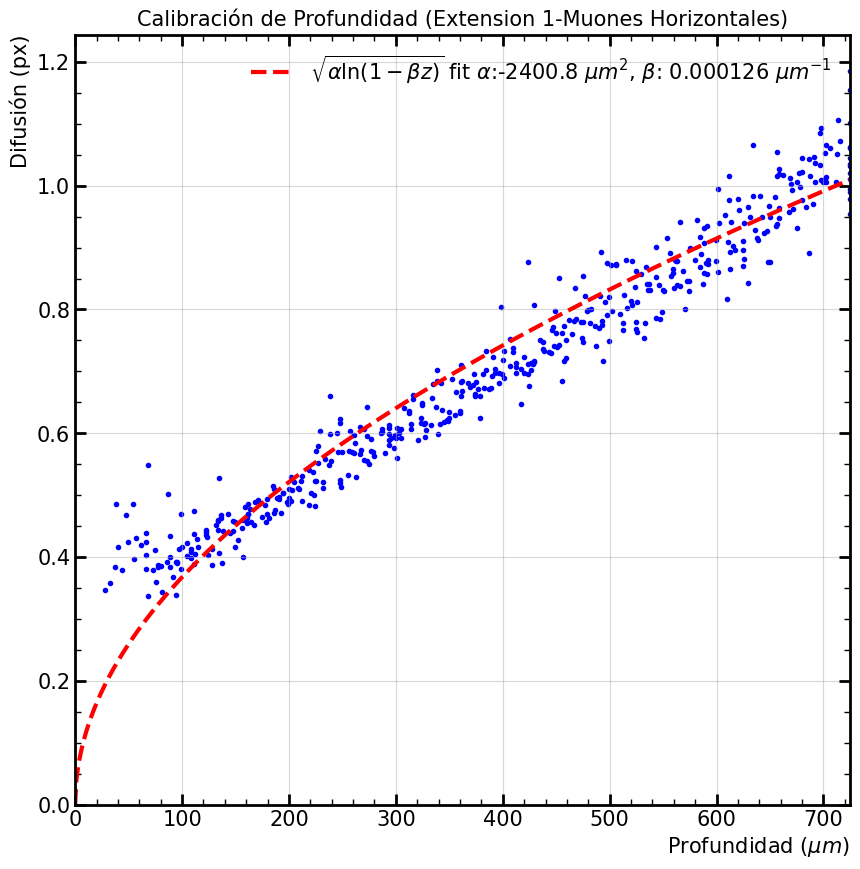

In [26]:
img_sigma = 0.0008  # KeV 
# print(img_sigma)
fig, axs_all = plt.subplots(figsize = [10,10])

# list_muonlabels = [256, 257, 258]

list_all_sigmas = []
list_all_deeps = []

for label_muon in list_muonlabels: 
    event = list_datamask[label_muon]
    size_x = event.shape[1]
    size_y = event.shape[0]

    # lines = 0
    Longitud_XY = size_x
    Z_inicial = (Delta_inicial * CCD_depth) / (Longitud_XY - Delta_final)
    # print('Muon: ', label_muon, ', Shape (X, Y): ', event.shape[1], event.shape[0])

    list_fitsigmas = []
    if label_muon in list_muonlabels2:
        Delta_inicial = Delta_final
        Delta_final = Delta_inicial

    for lable_line in range(Delta_inicial, size_x - Delta_final):
        line = event[:, lable_line: lable_line + 1]
        Carga_renglon = line.sum()
        Mean_carga = np.mean(line)
        Longitud_linea = len(line)


        Mean_in  = 0
        var = 0
        carga_cuadrada = 0

        ### Se calcula el X promedio ##
        for pixel in range(0, Longitud_linea):
            if line[pixel][0]:
                element_pixel = (pixel * line[pixel][0]) / Carga_renglon
                Mean_in = Mean_in + element_pixel
            else:
                element_pixel = 0
            
            Mean_in = Mean_in + element_pixel

        ## Calcula la suma de las cargas al cuadrado ##
        for pixel in range(0, Longitud_linea, 1):
            if line[pixel][0]:
                element_pixel = line[pixel][0]**2
            else:
                element_pixel = 0

            carga_cuadrada = carga_cuadrada + element_pixel 

        Mean_carga_cuadrada = carga_cuadrada/Longitud_linea

        ### Se calcula la varianza ##
        for pixel in range(0, Longitud_linea, 1):
            if line[pixel][0]:
                element_pixel =(1 / (Longitud_linea - 1)) * (pixel - Mean_in)**2 * line[pixel][0]
                var = var + element_pixel  ### COreggir la varianza con otro estimados

        ### Se corrige la varianza con la carga ###
        # var_true = var * (Mean_carga_cuadrada / (Mean_carga**2))
        var_true = var / Carga_renglon

        ### Se calcula la sigma ###
        sigma_in = np.sqrt(var)
        # print(sigma_in)
        # sigma_in = np.sqrt(var_true)


        ##Se crea un arreglo para usarlo en el plot de los datos, y se realiza el juste ##
        list_xlabel = np.arange(0.5, len(line), 1)


        ## Ajuste gaussiano con ROOT ##
        fgaus2 = TF1("fgauss","gaus",  0,  len(line), 3) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
        h3=TH1F("histogram", "Distribution of Line", len(line) + 1, 0,  len(line) )

        for index in range(0, len(line)):
            if line[index][0] != 0:
                # print(index, line[index])
                h3.SetBinContent( index + 1, line[index][0])
                h3.SetBinError(index + 1, img_sigma)
                # h3.SetBinError(index + 1, 0.001)
                #print(pixel_value)

        fgaus2.SetParameters(np.max(line),Mean_in,sigma_in) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
        h3.Fit(fgaus2, "RQN")

        fit_const = fgaus2.GetParameters()[0]
        fit_mean = fgaus2.GetParameters()[1]
        fit_sigma = fgaus2.GetParameters()[2]


        # fit_sigma = sigma_in
        # print('Sigma fit: ', fit_sigma)
        list_fitsigmas.append(fit_sigma)

        del h3

    list_deep = []
    list_xlabel_sigmas = np.linspace(Z_inicial, CCD_depth, len(list_fitsigmas))
    for deep in list_xlabel_sigmas:
        list_deep.append(deep)

    # if label_muon in (143, 302, 321, 362, 383, 385, 404, 434, 550, 793, 864, 929, 1090, 1091):
    #     # print('Gola', list_fitsigmas[0], list_fitsigmas[-1])
    #     list_fitsigmas.reverse()
    #     # print('Agios', list_fitsigmas[0], list_fitsigmas[-1], end='\n\n')
    if label_muon in list_muonlabels2:
        list_fitsigmas.reverse()
        
    for index in range(0, len(list_fitsigmas)):
        list_all_sigmas.append(list_fitsigmas[index])
        list_all_deeps.append(list_deep[index])

    # axs_all.scatter(list_deep, list_fitsigmas, marker='2', label = 'Muon: ' + str(label_muon))
del list_fitsigmas
del list_deep


fit_range = np.arange(0, 725)

axs_all.scatter(list_all_deeps, list_all_sigmas, marker='.', facecolor = 'b')

def diffution_curve(x, alpha, beta):
    return np.sqrt((alpha * np.log(1 - (beta * x))))

# popt_DM, _ = curve_fit(diffution_curve, list_all_deeps, list_all_sigmas, maxfev=100000, p0= [1, 1])
# dict_diffution_model = {'Alpha' : popt_DM[0], 'Beta' : popt_DM[1]}
# print('Alpha: ', dict_diffution_model['Alpha'], ' Beta: ', dict_diffution_model['Beta'])



axs_all.plot(fit_range, diffution_curve(fit_range, alpha=fit_alpha, beta=fit_beta)/15, '--r', linewidth = 3, label= Label)
# axs_all.plot(fit_range, diffution_curve(fit_range, -611, 0.00045)/15, '--r', linewidth = 3)

axs_all.set_title('Calibración de Profundidad (Extension 1-Muones Horizontales)', size = 15)#, y=0.92)}
axs_all.set_ylabel(r'Difusión (px)')
axs_all.set_xlabel(r'Profundidad ($\mu m$)')
axs_all.set_ylim(0,)
axs_all.set_xlim(0, 725)
axs_all.legend()
axs_all.grid()
plt.show()

In [27]:
list_all_sigmas = []
list_all_deeps = []

for label_muon in list_muonlabels: 
    event = list_datamask[label_muon]
    size_x = event.shape[1]
    size_y = event.shape[0]

    # lines = 0
    Longitud_XY = size_x
    Z_inicial = (Delta_inicial * CCD_depth) / (Longitud_XY - Delta_final)
    # print('Muon: ', label_muon, ', Shape (X, Y): ', event.shape[1], event.shape[0])

    list_fitsigmas = []
    if label_muon in list_muonlabels2:
        Delta_inicial = Delta_final
        Delta_final = Delta_inicial

    for lable_line in range(Delta_inicial, size_x - Delta_final):
        line = event[:, lable_line: lable_line + 1]
        Carga_renglon = line.sum()
        Mean_carga = np.mean(line)
        Longitud_linea = len(line)


        Mean_in  = 0
        var = 0
        carga_cuadrada = 0

        ### Se calcula el X promedio ##
        for pixel in range(0, Longitud_linea):
            if line[pixel][0]:
                element_pixel = (pixel * line[pixel][0]) / Carga_renglon
                Mean_in = Mean_in + element_pixel
            else:
                element_pixel = 0
            
            Mean_in = Mean_in + element_pixel

        ## Calcula la suma de las cargas al cuadrado ##
        for pixel in range(0, Longitud_linea, 1):
            if line[pixel][0]:
                element_pixel = line[pixel][0]**2
            else:
                element_pixel = 0

            carga_cuadrada = carga_cuadrada + element_pixel 

        Mean_carga_cuadrada = carga_cuadrada/Longitud_linea

        ### Se calcula la varianza ##
        for pixel in range(0, Longitud_linea, 1):
            if line[pixel][0]:
                element_pixel =(1 / (Longitud_linea - 1)) * (pixel - Mean_in)**2 * line[pixel][0]
                var = var + element_pixel  ### COreggir la varianza con otro estimados

        ### Se corrige la varianza con la carga ###
        # var_true = var * (Mean_carga_cuadrada / (Mean_carga**2))
        var_true = var / Carga_renglon

        ### Se calcula la sigma ###
        sigma_in = np.sqrt(var)
        # print(sigma_in)
        # sigma_in = np.sqrt(var_true)


        ##Se crea un arreglo para usarlo en el plot de los datos, y se realiza el juste ##
        list_xlabel = np.arange(0.5, len(line), 1)


        ## Ajuste gaussiano con ROOT ##
        fgaus2 = TF1("fgauss","gaus",  0,  len(line), 3) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
        h3=TH1F("histogram", "Distribution of Line", len(line) + 1, 0,  len(line) )

        for index in range(0, len(line)):
            if line[index][0] != 0:
                # print(index, line[index])
                h3.SetBinContent( index + 1, line[index][0])
                h3.SetBinError(index + 1, img_sigma)
                # h3.SetBinError(index + 1, 0.001)
                #print(pixel_value)

        fgaus2.SetParameters(np.max(line),Mean_in,sigma_in) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
        h3.Fit(fgaus2, "RQN")

        fit_const = fgaus2.GetParameters()[0]
        fit_mean = fgaus2.GetParameters()[1]
        fit_sigma = fgaus2.GetParameters()[2]


        # fit_sigma = sigma_in
        # print('Sigma fit: ', fit_sigma)
        list_fitsigmas.append(fit_sigma)

        del h3

    list_deep = []
    list_xlabel_sigmas = np.linspace(Z_inicial, CCD_depth, len(list_fitsigmas))
    for deep in list_xlabel_sigmas:
        list_deep.append(deep)

    if label_muon in list_muonlabels2:
        list_fitsigmas.reverse()

    for index in range(0, len(list_fitsigmas)):
        list_all_sigmas.append(list_fitsigmas[index])
        list_all_deeps.append(list_deep[index])

    # axs_all.scatter(list_deep, list_fitsigmas, marker='2', label = 'Muon: ' + str(label_muon))
del list_fitsigmas
del list_deep



# fit_range = np.arange(0, 900)
# axs_all.scatter(list_all_deeps, list_all_sigmas, marker='2')
 
h_model = TGraph(len(list_all_sigmas), np.array(list_all_deeps),np.array(list_all_sigmas))
h_model.SetMarkerStyle(2) # Set marker style (e.g., solid circle)
h_model.SetTitle("Modelo de dif. (Extensión 1- Muones Horizontales)")
h_model.GetXaxis().SetTitle("Profundidad (micras)")
h_model.GetYaxis().SetTitle("Anchura (micras)")
h_model.GetYaxis().SetRangeUser(0, 1.2)



Range_fit = [50, 725]
diff_curve = TF1("diff_curve", "sqrt(([0] * log(1 - [1]*x)))/15", Range_fit[0], Range_fit[1], 2) #np.sqrt(np.abs(alpha * np.log(1 - (beta * z))))

diff_curve.SetParameters(-200, 0.00001) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
h_model.Fit(diff_curve, "RNQ")

fit_alpha = diff_curve.GetParameters()[0]
fit_beta = diff_curve.GetParameters()[1]
chi2 = diff_curve.GetChisquare()
ndf = diff_curve.GetNDF()
prob = diff_curve.GetProb()

fit_alpha_err = diff_curve.GetParErrors()[0]
fit_beta_err = diff_curve.GetParErrors()[1]

print('Alpha: ', fit_alpha, '+- ', fit_alpha_err) 
print('Beta: ', fit_beta,  '+- ', fit_beta_err)
print('Chi2/ndf: ', chi2, '/', ndf)
print('Prob: ', prob)




c3=TCanvas("","", 1000, 600)
h_model.Draw("AP same")
diff_curve.Draw("same")
c3.Draw()

leg = TLegend(0.1,0.7,0.48,0.9)
leg.AddEntry(diff_curve, r"\sqrt{\alpha \log(1 - \beta z)} fit: \alpha= " + str(np.around(fit_alpha, 3)) + r" \mu m^2, \beta= " + str(np.around(fit_beta, 6)) + " \mu m^{-1}", "L")
leg.Draw()


Alpha:  -698.2582015030474 +-  113.8310041502938
Beta:  0.0003897430856499759 +-  5.67089986885664e-05
Chi2/ndf:  1.1537737652167428 / 475
Prob:  1.0


In [28]:
from array import array

spread_array = array('f', [-9999])
deep_array = array('f', [-9999])

location_file = './'
file_root_name = 'tree_DiffusionMod_Ext1_Horz.root'
file = TFile.Open(location_file  + file_root_name, "RECREATE")
tree = TTree('tree', 'tree')

tree.Branch('sprd', spread_array, 'sprd/F')
tree.Branch('deep', deep_array, 'deep/F')

for i in range(0, len(list_all_sigmas)):
    spread_array[0] = list_all_sigmas[i]
    deep_array[0] = list_all_deeps[i]
    
    tree.Fill()

tree.Write()
file.Close()

#### Ajuste vertical y horizontal

In [227]:
Range_fit = [0, 725]
diff_curve_1 = TF1("diff_curve_1", "sqrt(([0] * log(1 - [1]*x)))/15", Range_fit[0], Range_fit[1], 2)
# diff_curve_1.SetParameters(-804.301, 0.000339)
diff_curve_1.SetParameters(-698.258, 0.0003897)
diff_curve_1.SetLineColor(2)
diff_curve_1.SetTitle("Modelo de Difusión (Ext 1)")
diff_curve_1.GetXaxis().SetTitle("Profundidad (micras)")
diff_curve_1.GetYaxis().SetTitle("Anchura (px)")

diff_curve_2 = TF1("diff_curve_2", "sqrt(([0] * log(1 - [1]*x)))/15", Range_fit[0], Range_fit[1], 2)
diff_curve_2.SetParameters(-2400.842, 0.000126)
diff_curve_2.SetLineColor(4)

c3=TCanvas("","", 1000, 600)
diff_curve_1.Draw()
diff_curve_2.Draw("same")

leg = TLegend(0.1,0.7,0.48,0.9)
leg.AddEntry(diff_curve_1, "Muones Horizontales", "L")
leg.AddEntry(diff_curve_2, "Muones Verticales", "L")
leg.Draw()

c3.Draw()


# Extension 2

### Muones Verticales

#### Dataframe y Visualización

In [20]:
### Se crea el dataframe y se selecciona un rango de datos ###
Ext = 2
DF_muons, list_datamask = DataFrame_muons(data_histogram, extension=Ext)
# display(DF_muons[450:500])
list_newmatrix = []
list_indexs =[]
# range_in_phi = DF_muons[DF_muons['Phi (Deg)'].between(85, 95)] # Verticales arriba
range_in_phi = DF_muons[DF_muons['Phi (Deg)'].between(265, 275)] # Verticales abajo

for index in range_in_phi.index:
    # print(index)
    list_newmatrix.append(list_datamask[index])
    list_indexs.append(index)

print(list_indexs)
list_phi_ext1 = data_histogram['extension_' + str(Ext)]['phi']
list_mask_rot = []

list_listsnxny = []

for index in list_indexs[:]:
    datamask = list_datamask[index]
    ylen, xlen = datamask.shape
    list_nxny = []

    data_mask_zeros = np.empty((ylen + 90, xlen+50))
    data_mask_zeros[:] = 0
    ylen_zeros, xlen_zeros = data_mask_zeros.shape
    # print(data_mask_zeros.shape)
    
    ### Angle rot ##
    phi_rot = np.pi/2 - list_phi_ext1[index]
    # print(phi_rot, phi_rot + list_phi_ext1[index])

    # print('shape original: ', xlen, ylen)
    # print('shape zeros: ', xlen_zeros, ylen_zeros)

    for y_bin in range(0, ylen):
        for x_bin in range(0, xlen):
            if datamask[y_bin][x_bin] != 0:
                nx, ny = pixel_rot(x_bin=x_bin, x0=0, y_bin=y_bin, y0=0, theta= phi_rot)
                list_nxny.append((nx + 10, ny))
                # print(nx, ny)
                data_mask_zeros[ny][nx+10] = datamask[y_bin][x_bin]

    list_listsnxny.append(list_nxny)
    label_img, nlabels_img = sk.measure.label(data_mask_zeros > 0, connectivity=2, return_num=True)
    loc = nd.find_objects(label_img == 1)[0]
    mask_rot = np.invert(label_img==1)
    # data_mask_rot = ma.masked_array(data_mask_zeros, mask_rot)
    data_mask_rot = ma.masked_array(data_mask_zeros[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_rot[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])

    list_mask_rot.append(data_mask_rot)
    # print('Shape rot: ', data_mask_rot.shape[1], data_mask_rot.shape[0])
    
    # plt.imshow(data_mask_rot)
    # plt.show()

# print(list_mask_rot)
#     

[20, 26, 64, 108, 128, 194, 232, 301, 349, 386, 450, 487, 593, 697, 706, 744, 793, 869, 873, 881, 903, 925, 1053, 1091, 1100, 1141, 1145, 1160, 1167, 1175, 1254, 1276]


,date_run,Gain (ADU/e-),Solidity,Elipticity,Theta (Deg),Phi (Deg),Charge (KeV),l (cm),dEdL (KeV/cm)
Muon ID,,,,,,,,,
20,ENE2024,200.661131,0.901961,0.681085,25.387446,270.722991,232.609634,0.08025,2898.570317


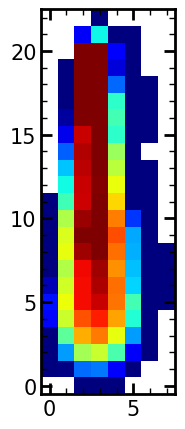

In [21]:
n_label = 20
display(DF_muons.iloc[[n_label]])

figure , axs = plt.subplots(1,1,figsize=[5,5])
# axs.imshow(list_mask_rot[n_label],  cmap = ColorMap, norm=Norm)  # 77, 1911, 2381, 2930 indices para path con elip 0.85, Sol 0.7
axs.imshow(list_datamask[n_label],  cmap = ColorMap, norm=Norm)  # 77, 1911, 2381, 2930 indices para path con elip 0.85, Sol 0.7
plt.show()


In [31]:
# list_index_long_muons = []
# extension = 1

# for index in range(0, len(list_mask_rot)):
#     size_x = list_mask_rot[index].shape[1]
#     size_y = list_mask_rot[index].shape[0]
#     if size_y > 50:
#         # print(size_x, size_y)
#         list_index_long_muons.append(index)

# # print(list_index_long_muons)+
# print('Muones largos detectados: ', len(list_index_long_muons))
# print('Indices: ', list_index_long_muons)

#### Perfil energético

25.38744638165865
Number of rows:  43


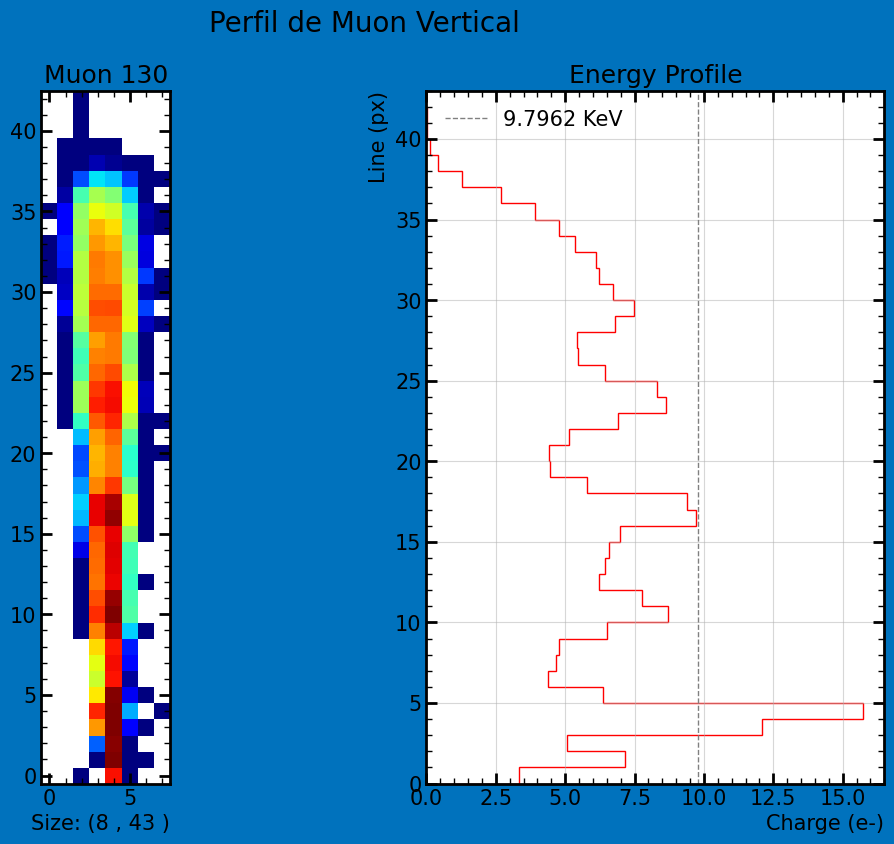

In [32]:
# list_muonlabels = [10, 15, 74, 91, 92, 112, 133, 176, 196, 256]  # Segunda revisión (están arriba)
muon_label = 130  # Se coloca directamente el label del evento
thet = DF_muons.iloc[[n_label]]['Theta (Deg)'].values[0]
print(thet)

Delta_inicial = 0
Delta_final = 0

fig, axs = plt.subplots(ncols=2, nrows=1, figsize = [13,9], facecolor = [0, 0.4470, 0.7410])
fig.suptitle('Perfil de Muon Vertical', y = 0.97, size = 20)
event = list_datamask[muon_label]
# plt.imshow(event)

size_x = event.shape[1] # tamaño en x
size_y = event.shape[0] # tamaño en y
# print(event.sum())

print('Number of rows: ', event.shape[0])
charge_verticalMuon = []
for index in range(1, size_y):
    line = event[index - 1:index][0]
    charge = line.sum()
    charge_verticalMuon.append(charge)

        
# cmap = 'plasma'
axs[0].imshow(event, cmap = ColorMap, norm = Norm)#, origin='upper')
axs[0].set_title('Muon ' + str(muon_label))
axs[0].set_xlabel('Size: (' + str(size_x) + ' , ' + str(size_y) + ' )')
# x0bar = fig.colorbar(x0, ax=axs[0])

en_cor = 4.2 /np.sin(np.radians(thet))
axs[1].stairs(charge_verticalMuon, range(0,len(charge_verticalMuon)+1),  orientation='horizontal', color = 'r')#,  hatch = '////')
axs[1].axvline(en_cor, 0, size_y+2, linestyle='--', color='gray', label = str(np.around(en_cor, 4)) +' KeV')
# axs[1].vlines(x = mean_charge, ymin = 0, ymax = len(event) - 1, color = 'k', label = 'Mean Charge \n' + str(mean_charge))

axs[1].set_ylim(0, size_y)
# axs[1].set_xlim(0, 4000)


# axs[1].set_xlabel('Charge (KeV)')
axs[1].set_xlabel('Charge (e-)')
axs[1].set_ylabel('Line (px)')
# axs[1].set_ylim(0,len(event) - 1 )
axs[1].set_title('Energy Profile')
axs[1].legend()
axs[1].grid()
plt.show()

#### Modelo de Diff

In [22]:
CCD_depth = 725 # micras
Delta_inicial = 3    # px
Delta_final = 6     # px
Bins = 50

extension = 2
label_muon = 130
lable_line = 12
img_sigma = 0.0003  # KeV 
# print(img_sigma)

## Se checa si el muon tiene la orientación correcta
event = list_datamask[label_muon]
size_x = event.shape[1]
size_y = event.shape[0]

# lines = 0
Longitud_XY = size_y 
Longitud_linea = size_x

Z_inicial = (Delta_inicial * CCD_depth) / (Longitud_XY - Delta_final)


line = event[lable_line - 1:lable_line][0]
Carga_renglon = line.sum()
Mean_carga = np.mean(line)


Mean_in  = 0
var = 0
carga_cuadrada = 0

### Se calcula el X promedio ##
for pixel in np.arange(0, Longitud_linea, 1):
    if line[pixel]:
        element_pixel = (pixel * line[pixel]) / Carga_renglon
        Mean_in = Mean_in + element_pixel
    else:
        element_pixel = 0
    
    Mean_in = Mean_in + element_pixel

## Calcula la suma de las cargas al cuadrado ##
for pixel in np.arange(0, Longitud_linea, 1):
    if line[pixel]:
        element_pixel = line[pixel]**2
    else:
        element_pixel = 0

    carga_cuadrada = carga_cuadrada + element_pixel 

Mean_carga_cuadrada = carga_cuadrada/Longitud_linea

### Se calcula la varianza ##
for pixel in np.arange(0, Longitud_linea, 1):
    element_pixel =(1 / (Longitud_linea - 1)) * (pixel - Mean_in)**2
    var = var + element_pixel  ### COreggir la varianza con otro estimados

### Se corrige la varianza con la carga ###
var_true = var * (Mean_carga_cuadrada / (Mean_carga**2))

### Se calcula la sigma ###
sigma_in = np.sqrt(var)
# sigma_in = np.sqrt(var_true)


##Se crea un arreglo para usarlo en el plot de los datos, y se realiza el juste ##
list_xlabel = np.arange(0.5, len(line), 1)

# list_xlabel_long = np.linspace(-Longitud_linea + int(Longitud_linea/2) , Longitud_linea + int(Longitud_linea/2), Longitud_linea)

# popt, pcov = curve_fit(gaussian, list_xlabel, data_mask[0], maxfev=100000, p0 = [8000, Mean_in, sigma_in])		# Fit histogram with gaussian

print('Lonitud de la linea: ', len(line.flatten()))

## Ajuste gaussiano con ROOT ##
fgaus2 = TF1("fgauss","gaus",  0,  len(line.flatten()), 3) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
h3=TH1F("histogram", "Distribution of Line", len(line.flatten()) + 1, 0,  len(line.flatten()) )

for index in range(0, len(line)):
    if line[index] != 0:
        # print(index, line[index])
        h3.SetBinContent( index + 1, line[index])
        h3.SetBinError(index + 1, img_sigma)
        # h3.SetBinError(index + 1, 0.001)
        #print(pixel_value)

fgaus2.SetParameters(np.max(line),Mean_in,sigma_in) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
h3.Fit(fgaus2, "RQN")

fit_const = fgaus2.GetParameters()[0]
fit_mean = fgaus2.GetParameters()[1]
fit_sigma = fgaus2.GetParameters()[2]
print('Sigma fit: ', fit_sigma, end='\n\n')

c3=TCanvas()

h3.Draw()
c3.Draw()
fgaus2.Draw("same")
# gStyle.SetOptFit(1100)
# gStyle.SetPadGridX (True)



# plt.show()

Lonitud de la linea:  8
Sigma fit:  0.5363004375113769



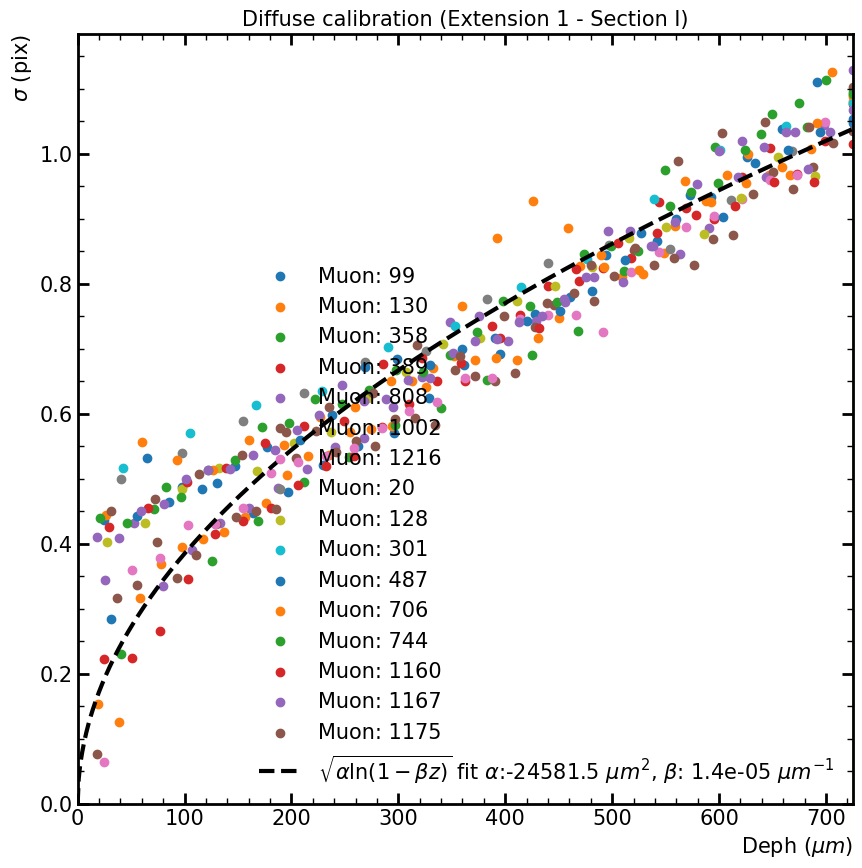

In [26]:
CCD_depth = 725 # micras
Delta_inicial = 4    # px
Delta_final = 5     # px
Bins = 50

extension = 1
label_muon = 1
img_sigma = 0.0008  # KeV 
# print(img_sigma)
fig, axs_all = plt.subplots(figsize = [10,10])

# Data for 85 to 95 
# [65, 92, 99, 112, 130, 136, 145, 149, 182, 191, 358, 389, 449, 482, 545, 550, 678, 771, 795, 808, 820, 939, 940, 947, 954, 956, 1002, 1133, 1164, 1166, 1216, 1220, 1337]


# Data for 265 to 275
# [20, 26, 64, 108, 128, 194, 232, 301, 349, 386, 450, 487, 593, 697, 706, 744, 793, 869, 873, 881, 903, 925, 1053, 1091, 1100, 1141, 1145, 1160, 1167, 1175, 1254, 1276]


list_muonlabels0 = [99, 130, 358, 389, 808, 1002, 1216] # AL 149 se disparan los valores iniciales
list_muonlabels1 = [20, 128, 301, 487, 706, 744, 1160, 1167, 1175]


list_muonlabels = list_muonlabels0 + list_muonlabels1
# list_muonlabels = list_muonlabels1


for label_muon in list_muonlabels: 
    Delta_inicial = 1    # px
    Delta_final = 5     # px
    event = list_datamask[label_muon]
    size_x = event.shape[1]
    size_y = event.shape[0]

    # lines = 0
    Longitud_XY = size_y 
    Z_inicial = (Delta_inicial * CCD_depth) / (Longitud_XY - Delta_final)
    # print('Muon: ', label_muon, ', Shape (X, Y): ', event.shape[1], event.shape[0])

    list_fitsigmas = []
    if label_muon in list_muonlabels1:
        Delta_inicial = Delta_final
        Delta_final = Delta_inicial


    for lable_line in range(Delta_inicial, size_y - Delta_final):
        line = event[lable_line - 1:lable_line][0]
        Carga_renglon = line.sum()
        Mean_carga = np.mean(line)
        Longitud_linea = len(line)


        Mean_in  = 0
        var = 0
        carga_cuadrada = 0

        ### Se calcula el X promedio ##
        for pixel in range(0, Longitud_linea):
            if line[pixel]:
                element_pixel = (pixel * line[pixel]) / Carga_renglon
                Mean_in = Mean_in + element_pixel
            else:
                element_pixel = 0
            
            Mean_in = Mean_in + element_pixel

        ## Calcula la suma de las cargas al cuadrado ##
        for pixel in np.arange(0, Longitud_linea, 1):
            if line[pixel]:
                element_pixel = line[pixel]**2
            else:
                element_pixel = 0

            carga_cuadrada = carga_cuadrada + element_pixel 

        Mean_carga_cuadrada = carga_cuadrada/Longitud_linea

        ### Se calcula la varianza ##
        for pixel in np.arange(0, Longitud_linea, 1):
            if line[pixel]:
                element_pixel =(1 / (Longitud_linea - 1)) * (pixel - Mean_in)**2 * line[pixel]
                var = var + element_pixel  ### COreggir la varianza con otro estimados

        ### Se corrige la varianza con la carga ###
        # var_true = var * (Mean_carga_cuadrada / (Mean_carga**2))
        var_true = var / Carga_renglon

        ### Se calcula la sigma ###
        sigma_in = np.sqrt(var_true)
        # print(sigma_in)
        # sigma_in = np.sqrt(var_true)


        ##Se crea un arreglo para usarlo en el plot de los datos, y se realiza el juste ##
        list_xlabel = np.arange(0.5, len(line), 1)


        ## Ajuste gaussiano con ROOT ##
        fgaus2 = TF1("fgauss","gaus",  0,  len(line.flatten()), 3) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
        h3=TH1F("histogram", "Distribution of Line", len(line.flatten()) + 1, 0,  len(line.flatten()) )

        for index in range(0, len(line)):
            if line[index] != 0:
                # print(index, line[index])
                h3.SetBinContent( index + 1, line[index])
                h3.SetBinError(index + 1, img_sigma)
                # h3.SetBinError(index + 1, 0.001)
                #print(pixel_value)

        fgaus2.SetParameters(np.max(line),Mean_in,sigma_in) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
        h3.Fit(fgaus2, "RQN")

        fit_const = fgaus2.GetParameters()[0]
        fit_mean = fgaus2.GetParameters()[1]
        fit_sigma = fgaus2.GetParameters()[2]


        # fit_sigma = sigma_in
        # print('Sigma fit: ', fit_sigma)
        list_fitsigmas.append(fit_sigma)

        del h3

    list_deep = []
    list_xlabel_sigmas = np.linspace(Z_inicial, CCD_depth, len(list_fitsigmas))
    for deep in list_xlabel_sigmas:
        list_deep.append(deep)

    if label_muon in list_muonlabels1:
    #     # print('Gola', list_fitsigmas[0], list_fitsigmas[-1])
        list_fitsigmas.reverse()
    #     # print('Agios', list_fitsigmas[0], list_fitsigmas[-1], end='\n\n')

    axs_all.scatter(list_deep, list_fitsigmas, label = 'Muon: ' + str(label_muon))
    # axs_all.scatter(list_deep, list_fitsigmas)


def diffution_curve(z, alpha, beta):
    return np.sqrt((alpha * np.log(1 - (beta * z))))

fit_range = np.arange(0, 725)
Label = r'$\sqrt{\alpha \ln(1 - \beta z)}$ fit $\alpha$:' + str(np.around(fit_alpha, 1)) + r' $\mu m^{2}$, $\beta$: ' + str(np.around(fit_beta, 6)) + r' $\mu m^{-1}$'

# axs_all.plot(fit_range, diffution_curve(fit_range, alpha=-200, beta=0.001) / 15, '--r', linewidth = 3)
axs_all.plot(fit_range, diffution_curve(fit_range, alpha=fit_alpha, beta=fit_beta)/15, '--k', linewidth = 3, label= Label)
# axs_all.plot(fit_range, diffution_curve(fit_range, alpha=-292.4325743170209, beta=3.990904646095944e-06), '--c', linewidth = 2, label='Fit CONNIE')

axs_all.set_title('Diffuse calibration (Extension 1 - Section I)', size = 15)#, y=0.92)}
axs_all.set_ylabel(r'$\sigma$ (pix)')
axs_all.set_xlabel(r'Deph ($\mu m$)')
axs_all.set_ylim(0, )
axs_all.set_xlim(0, 725)
axs_all.legend()
axs_all.grid
plt.show()

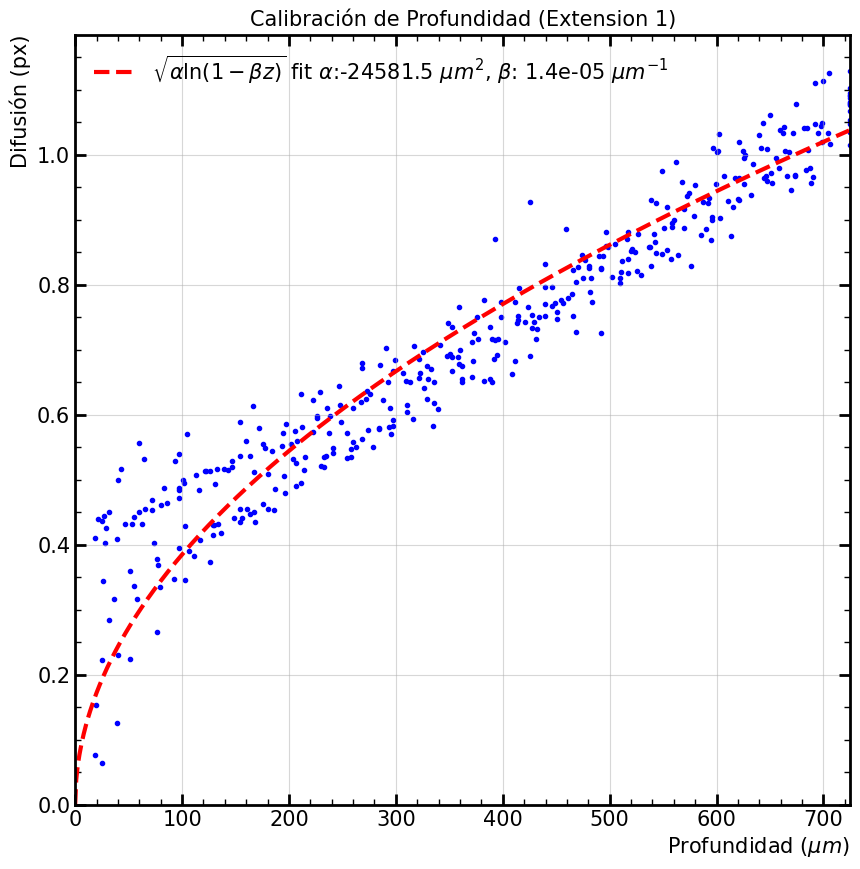

In [27]:
img_sigma = 0.0008  # KeV 
# print(img_sigma)
fig, axs_all = plt.subplots(figsize = [10,10])

# list_muonlabels = [256, 257, 258]

list_all_sigmas = []
list_all_deeps = []

for label_muon in list_muonlabels: 
    Delta_inicial = 1    # px
    Delta_final = 5     # px
    event = list_datamask[label_muon]
    size_x = event.shape[1]
    size_y = event.shape[0]

    # lines = 0
    Longitud_XY = size_y 
    Z_inicial = (Delta_inicial * CCD_depth) / (Longitud_XY - Delta_final)
    # print('Muon: ', label_muon, ', Shape (X, Y): ', event.shape[1], event.shape[0])

    list_fitsigmas = []
    if label_muon in list_muonlabels1:
        Delta_inicial = Delta_final
        Delta_final = Delta_inicial

    for lable_line in range(Delta_inicial, size_y - Delta_final):
        line = event[lable_line - 1:lable_line][0]
        Carga_renglon = line.sum()
        Mean_carga = np.mean(line)
        Longitud_linea = len(line)


        Mean_in  = 0
        var = 0
        carga_cuadrada = 0

        ### Se calcula el X promedio ##
        for pixel in range(0, Longitud_linea):
            if line[pixel]:
                element_pixel = (pixel * line[pixel]) / Carga_renglon
                Mean_in = Mean_in + element_pixel
            else:
                element_pixel = 0
            
            Mean_in = Mean_in + element_pixel

        ## Calcula la suma de las cargas al cuadrado ##
        for pixel in np.arange(0, Longitud_linea, 1):
            if line[pixel]:
                element_pixel = line[pixel]**2
            else:
                element_pixel = 0

            carga_cuadrada = carga_cuadrada + element_pixel 

        Mean_carga_cuadrada = carga_cuadrada/Longitud_linea

        ### Se calcula la varianza ##
        for pixel in np.arange(0, Longitud_linea, 1):
            if line[pixel]:
                element_pixel =(1 / (Longitud_linea - 1)) * (pixel - Mean_in)**2 * line[pixel]
                var = var + element_pixel  ### COreggir la varianza con otro estimados

        ### Se corrige la varianza con la carga ###
        # var_true = var * (Mean_carga_cuadrada / (Mean_carga**2))
        var_true = var / Carga_renglon

        ### Se calcula la sigma ###
        sigma_in = np.sqrt(var)
        # print(sigma_in)
        # sigma_in = np.sqrt(var_true)


        ##Se crea un arreglo para usarlo en el plot de los datos, y se realiza el juste ##
        list_xlabel = np.arange(0.5, len(line), 1)


        ## Ajuste gaussiano con ROOT ##
        fgaus2 = TF1("fgauss","gaus",  0,  len(line.flatten()), 3) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
        h3=TH1F("histogram", "Distribution of Line", len(line.flatten()) + 1, 0,  len(line.flatten()) )

        for index in range(0, len(line)):
            if line[index] != 0:
                # print(index, line[index])
                h3.SetBinContent( index + 1, line[index])
                h3.SetBinError(index + 1, img_sigma)
                # h3.SetBinError(index + 1, 0.001)
                #print(pixel_value)

        fgaus2.SetParameters(np.max(line),Mean_in,sigma_in) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
        h3.Fit(fgaus2, "RQN")

        fit_const = fgaus2.GetParameters()[0]
        fit_mean = fgaus2.GetParameters()[1]
        fit_sigma = fgaus2.GetParameters()[2]


        # fit_sigma = sigma_in
        # print('Sigma fit: ', fit_sigma)
        list_fitsigmas.append(fit_sigma)

        del h3

    list_deep = []
    list_xlabel_sigmas = np.linspace(Z_inicial, CCD_depth, len(list_fitsigmas))
    for deep in list_xlabel_sigmas:
        list_deep.append(deep)

    if label_muon in list_muonlabels1:
        # print('Gola', list_fitsigmas[0], list_fitsigmas[-1])
        list_fitsigmas.reverse()
        # print('Agios', list_fitsigmas[0], list_fitsigmas[-1], end='\n\n')
        
    for index in range(0, len(list_fitsigmas)):
        list_all_sigmas.append(list_fitsigmas[index])
        list_all_deeps.append(list_deep[index])

    # axs_all.scatter(list_deep, list_fitsigmas, marker='2', label = 'Muon: ' + str(label_muon))
del list_fitsigmas
del list_deep


fit_range = np.arange(0, 725)



axs_all.scatter(list_all_deeps, list_all_sigmas, marker='.', facecolor = 'b')

def diffution_curve(x, alpha, beta):
    return np.sqrt((alpha * np.log(1 - (beta * x))))

# popt_DM, _ = curve_fit(diffution_curve, list_all_deeps, list_all_sigmas, maxfev=100000, p0= [1, 1])
# dict_diffution_model = {'Alpha' : popt_DM[0], 'Beta' : popt_DM[1]}
# print('Alpha: ', dict_diffution_model['Alpha'], ' Beta: ', dict_diffution_model['Beta'])



axs_all.plot(fit_range, diffution_curve(fit_range, alpha=fit_alpha, beta=fit_beta)/15, '--r', linewidth = 3, label= Label)
# axs_all.plot(fit_range, diffution_curve(fit_range, -611, 0.00045)/15, '--r', linewidth = 3)

axs_all.set_title('Calibración de Profundidad (Extension 1)', size = 15)#, y=0.92)}
axs_all.set_ylabel(r'Difusión (px)')
axs_all.set_xlabel(r'Profundidad ($\mu m$)')
axs_all.set_ylim(0,)
axs_all.set_xlim(0, 725)
axs_all.legend()
axs_all.grid()
plt.show()

In [28]:
list_all_sigmas = []
list_all_deeps = []

for label_muon in list_muonlabels: 
    Delta_inicial = 1    # px
    Delta_final = 5     # px
    event = list_datamask[label_muon]
    size_x = event.shape[1]
    size_y = event.shape[0]

    # lines = 0
    Longitud_XY = size_y 
    Z_inicial = (Delta_inicial * CCD_depth) / (Longitud_XY - Delta_final)
    # print('Muon: ', label_muon, ', Shape (X, Y): ', event.shape[1], event.shape[0])

    list_fitsigmas = []
    if label_muon in list_muonlabels1:
        Delta_inicial = Delta_final
        Delta_final = Delta_inicial

    for lable_line in range(Delta_inicial, size_y - Delta_final):
        line = event[lable_line - 1:lable_line][0]
        Carga_renglon = line.sum()
        Mean_carga = np.mean(line)
        Longitud_linea = len(line)


        Mean_in  = 0
        var = 0
        carga_cuadrada = 0

        ### Se calcula el X promedio ##
        for pixel in range(0, Longitud_linea):
            if line[pixel]:
                element_pixel = (pixel * line[pixel]) / Carga_renglon
                Mean_in = Mean_in + element_pixel
            else:
                element_pixel = 0
            
            Mean_in = Mean_in + element_pixel

        ## Calcula la suma de las cargas al cuadrado ##
        for pixel in np.arange(0, Longitud_linea, 1):
            if line[pixel]:
                element_pixel = line[pixel]**2
            else:
                element_pixel = 0

            carga_cuadrada = carga_cuadrada + element_pixel 

        Mean_carga_cuadrada = carga_cuadrada/Longitud_linea

        ### Se calcula la varianza ##
        for pixel in np.arange(0, Longitud_linea, 1):
            if line[pixel]:
                element_pixel =(1 / (Longitud_linea - 1)) * (pixel - Mean_in)**2 * line[pixel]
                var = var + element_pixel  ### COreggir la varianza con otro estimados

        ### Se corrige la varianza con la carga ###
        # var_true = var * (Mean_carga_cuadrada / (Mean_carga**2))
        var_true = var / Carga_renglon

        ### Se calcula la sigma ###
        sigma_in = np.sqrt(var)
        # print(sigma_in)
        # sigma_in = np.sqrt(var_true)


        ##Se crea un arreglo para usarlo en el plot de los datos, y se realiza el juste ##
        list_xlabel = np.arange(0.5, len(line), 1)


        ## Ajuste gaussiano con ROOT ##
        fgaus2 = TF1("fgauss","gaus",  0,  len(line.flatten()), 3) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
        h3=TH1F("histogram", "Distribution of Line", len(line.flatten()) + 1, 0,  len(line.flatten()) )

        for index in range(0, len(line)):
            if line[index] != 0:
                # print(index, line[index])
                h3.SetBinContent( index + 1, line[index])
                h3.SetBinError(index + 1, img_sigma)
                # h3.SetBinError(index + 1, 0.001)
                #print(pixel_value)

        fgaus2.SetParameters(np.max(line),Mean_in,sigma_in) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
        h3.Fit(fgaus2, "RQN")

        fit_const = fgaus2.GetParameters()[0]
        fit_mean = fgaus2.GetParameters()[1]
        fit_sigma = fgaus2.GetParameters()[2]


        # fit_sigma = sigma_in
        # print('Sigma fit: ', fit_sigma)
        list_fitsigmas.append(fit_sigma)

        del h3

    list_deep = []
    list_xlabel_sigmas = np.linspace(Z_inicial, CCD_depth, len(list_fitsigmas))
    for deep in list_xlabel_sigmas:
        list_deep.append(deep)

    if label_muon in list_muonlabels1:
        # print('Gola', list_fitsigmas[0], list_fitsigmas[-1])
        list_fitsigmas.reverse()
        # print('Agios', list_fitsigmas[0], list_fitsigmas[-1], end='\n\n')

    for index in range(0, len(list_fitsigmas)):
        list_all_sigmas.append(list_fitsigmas[index])
        list_all_deeps.append(list_deep[index])

    # axs_all.scatter(list_deep, list_fitsigmas, marker='2', label = 'Muon: ' + str(label_muon))
del list_fitsigmas
del list_deep



# fit_range = np.arange(0, 900)
# axs_all.scatter(list_all_deeps, list_all_sigmas, marker='2')
 
h_model = TGraph(len(list_all_sigmas), np.array(list_all_deeps),np.array(list_all_sigmas))
h_model.SetMarkerStyle(2) # Set marker style (e.g., solid circle)
h_model.SetTitle("Modelo de dif. (Extensión 2- Muones Verticales)")
h_model.GetXaxis().SetTitle("Profundidad (micras)")
h_model.GetYaxis().SetTitle("Anchura (micras)")
h_model.SetStats(0)
h_model.GetXaxis().SetRangeUser(0, 725)
h_model.GetYaxis().SetRangeUser(0, 1.4)



Range_fit = [0, 725]
diff_curve = TF1("diff_curve", "sqrt(([0] * log(1 - [1]*x)))/15", Range_fit[0], Range_fit[1], 2) #np.sqrt(np.abs(alpha * np.log(1 - (beta * z))))

diff_curve.SetParameters(-200, 0.00001) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
h_model.Fit(diff_curve, "RNQ")

fit_alpha = diff_curve.GetParameters()[0]
fit_beta = diff_curve.GetParameters()[1]
chi2 = diff_curve.GetChisquare()
ndf = diff_curve.GetNDF()
prob = diff_curve.GetProb()

fit_alpha_err = diff_curve.GetParErrors()[0]
fit_beta_err = diff_curve.GetParErrors()[1]

print('Alpha: ', fit_alpha, '+- ', fit_alpha_err) 
print('Beta: ', fit_beta,  '+- ', fit_beta_err)
print('Chi2/ndf: ', chi2, '/', ndf)
print('Prob: ', prob)

c3=TCanvas("","", 1000, 600)
h_model.Draw("AP same")
diff_curve.Draw("same")
c3.Draw()

leg = TLegend(0.1,0.7,0.48,0.9)
leg.AddEntry(diff_curve, r"\sqrt{\alpha \log(1 - \beta z)} fit: \alpha= " + str(np.around(fit_alpha, 3)) + r" \mu m^2, \beta= " + str(np.around(fit_beta, 6)) + " \mu m^{-1}", "L")
leg.Draw()

Alpha:  -12118.340781328252 +-  3946.135893628133
Beta:  2.6908507179649492e-05 +-  8.97767248124544e-06
Chi2/ndf:  1.9877903408258168 / 390
Prob:  1.0


In [29]:
from array import array

spread_array = array('f', [-9999])
deep_array = array('f', [-9999])

location_file = './'
file_root_name = 'tree_DiffusionMod_Ext2_Vert.root'
file = TFile.Open(location_file  + file_root_name, "RECREATE")
tree = TTree('tree', 'tree')

tree.Branch('sprd', spread_array, 'sprd/F')
tree.Branch('deep', deep_array, 'deep/F')

for i in range(0, len(list_all_sigmas)):
    spread_array[0] = list_all_sigmas[i]
    deep_array[0] = list_all_deeps[i]
    
    tree.Fill()

tree.Write()
file.Close()

### Muones Horizontales

#### DataFrame y visualización

In [38]:
### Se crea el dataframe y se selecciona un rango de datos ###
Ext = 2
DF_muons, list_datamask = DataFrame_muons(data_histogram, extension=Ext)
# display(DF_muons[450:500])
list_newmatrix = []
list_indexs =[]
#
# range_in_phi = DF_muons[DF_muons['Phi (Deg)'].between(0, 5)]    # Horizontales derecha
# range_in_phi = DF_muons[DF_muons['Phi (Deg)'].between(355, 360)]

range_in_phi = DF_muons[DF_muons['Phi (Deg)'].between(175, 185)] # Horizontales izquierda

for index in range_in_phi.index:
    # print(index)
    list_newmatrix.append(list_datamask[index])
    list_indexs.append(index)

print(list_indexs)
list_phi_ext1 = data_histogram['extension_' + str(Ext)]['phi']
list_mask_rot = []

list_listsnxny = []

for index in list_indexs[:]:
    datamask = list_datamask[index]
    ylen, xlen = datamask.shape
    list_nxny = []

    data_mask_zeros = np.empty((ylen + 90, xlen+50))
    data_mask_zeros[:] = 0
    ylen_zeros, xlen_zeros = data_mask_zeros.shape
    # print(data_mask_zeros.shape)
    
    ### Angle rot ##
    phi_rot = np.pi/2 - list_phi_ext1[index]
    # print(phi_rot, phi_rot + list_phi_ext1[index])

    # print('shape original: ', xlen, ylen)
    # print('shape zeros: ', xlen_zeros, ylen_zeros)

    # for y_bin in range(0, ylen):
    #     for x_bin in range(0, xlen):
    #         if datamask[y_bin][x_bin] != 0:
    #             nx, ny = pixel_rot(x_bin=x_bin, x0=0, y_bin=y_bin, y0=0, theta= phi_rot)
    #             list_nxny.append((nx + 200, ny))
    #             # print(nx, ny)
    #             data_mask_zeros[ny][nx+200] = datamask[y_bin][x_bin]

    # list_listsnxny.append(list_nxny)
    # label_img, nlabels_img = sk.measure.label(data_mask_zeros > 0, connectivity=2, return_num=True)
    # loc = nd.find_objects(label_img == 1)[0]
    # mask_rot = np.invert(label_img==1)
    # # data_mask_rot = ma.masked_array(data_mask_zeros, mask_rot)
    # data_mask_rot = ma.masked_array(data_mask_zeros[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_rot[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])

    # list_mask_rot.append(data_mask_rot)
    # print('Shape rot: ', data_mask_rot.shape[1], data_mask_rot.shape[0])
    
    # plt.imshow(data_mask_rot)
    # plt.show()

# print(list_mask_rot)
#     

[5, 43, 47, 50, 81, 96, 104, 170, 192, 209, 219, 228, 238, 241, 246, 252, 265, 285, 313, 347, 372, 379, 388, 399, 411, 433, 442, 524, 565, 568, 591, 701, 723, 766, 768, 785, 786, 821, 835, 838, 839, 841, 846, 859, 860, 879, 889, 899, 909, 921, 945, 957, 965, 986, 997, 1016, 1043, 1069, 1073, 1080, 1086, 1116, 1131, 1137, 1153, 1154, 1157, 1206, 1225, 1247, 1248, 1330]


,date_run,Gain (ADU/e-),Solidity,Elipticity,Theta (Deg),Phi (Deg),Charge (KeV),l (cm),dEdL (KeV/cm)
Muon ID,,,,,,,,,
37,ENE2024,210.247937,0.808777,0.906346,50.73088,3.968713,272.200378,0.114541,2376.454664


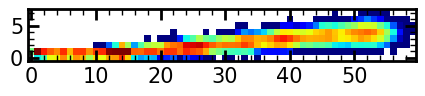

In [39]:
n_label = 37
display(DF_muons.iloc[[n_label]])

figure , axs = plt.subplots(1,1,figsize=[5,5])
# axs.imshow(list_mask_rot[n_label],  cmap = ColorMap, norm=Norm)  
axs.imshow(list_datamask[n_label],  cmap = ColorMap, norm=Norm)
plt.show()


Numper of rows:  8
Long of line:  6


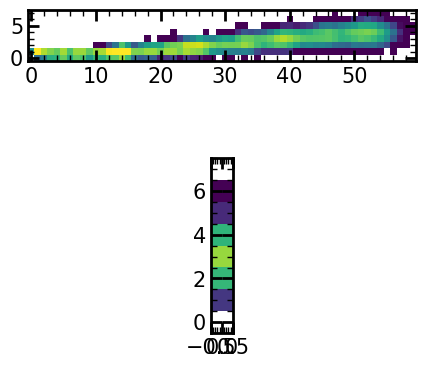

In [40]:
figure , axs = plt.subplots(2,1,figsize=[5,5])

label_muon = n_label
label_line = 40
muon = list_datamask[label_muon]
print('Numper of rows: ', muon.shape[0])
line = muon[:, label_line: label_line + 1]
# line = list_mask_rot[label_muon][label_line - 1:label_line][0]

n_longline = 0
for pixel in line:
    if pixel[0] != 0:
        # print(pixel)
        n_longline += 1

print('Long of line: ', n_longline)

# axs[0].imshow(list_mask_rot[label_muon], norm = Norm)
# axs[1].imshow(list_mask_rot[label_muon][label_line - 1:label_line], norm = Norm)

axs[0].imshow(muon, norm = Norm)
axs[1].imshow(muon[:, label_line: label_line + 1], norm = Norm)
plt.show()

#### Perfil energético

50.73087979068733
Number of rows:  8


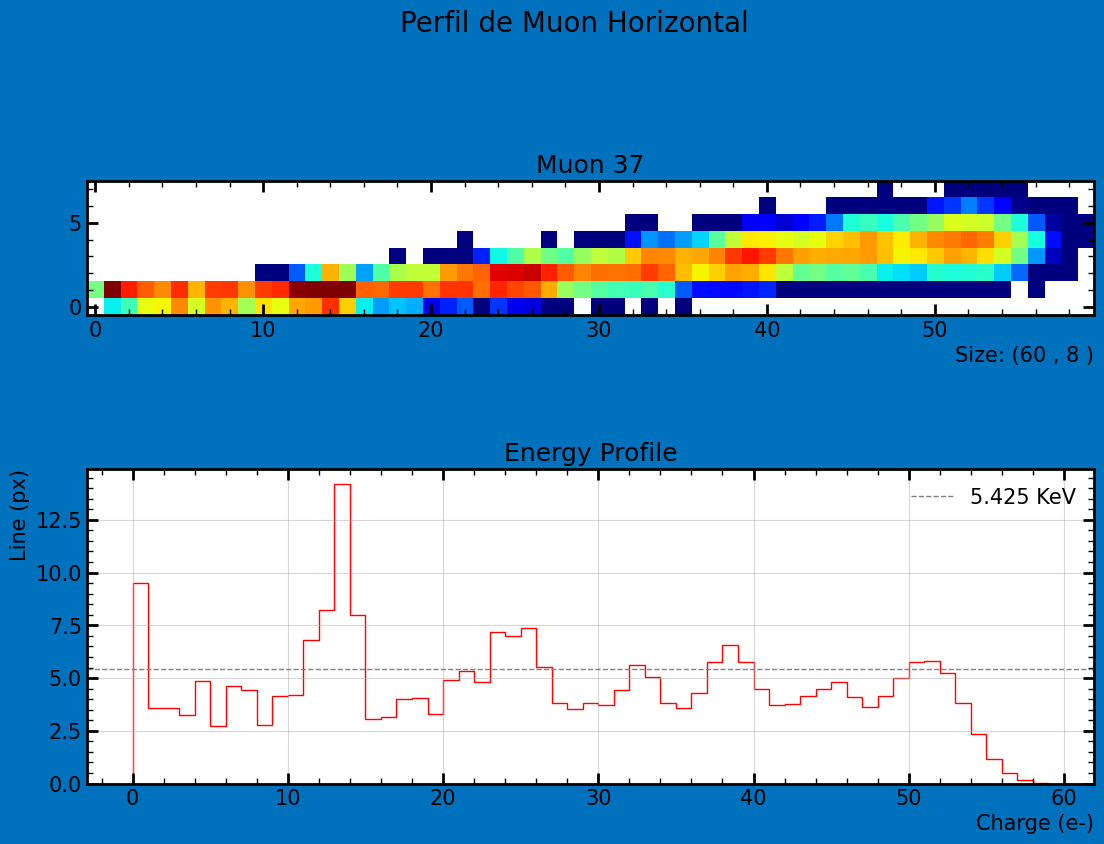

In [41]:
muon_label = 37  # Se coloca directamente el label del evento
thet = DF_muons.iloc[[n_label]]['Theta (Deg)'].values[0]
print(thet)

Delta_inicial = 0
Delta_final = 0
extension = 1

fig, axs = plt.subplots(ncols=1, nrows=2, figsize = [13,9], facecolor = [0, 0.4470, 0.7410])
fig.suptitle('Perfil de Muon Horizontal', y = 0.97, size = 20)
event = list_datamask[muon_label]
# plt.imshow(event)

size_x = event.shape[1] # tamaño en x
size_y = event.shape[0] # tamaño en y
# print(event.sum())

print('Number of rows: ', event.shape[0])
charge_horizontalMuon = []
for index in range(1, size_x):
    line = event[:, index: index + 1]
    charge = line.sum()
    charge_horizontalMuon.append(charge)

        
# cmap = 'plasma'
axs[0].imshow(event, cmap = ColorMap, norm = Norm)#, origin='upper')
axs[0].set_title('Muon ' + str(muon_label))
axs[0].set_xlabel('Size: (' + str(size_x) + ' , ' + str(size_y) + ' )')
# x0bar = fig.colorbar(x0, ax=axs[0])

en_cor = 4.2 /np.sin(np.radians(thet))
axs[1].stairs(charge_horizontalMuon, range(0,len(charge_horizontalMuon)+1),  orientation='vertical', color = 'r')#,  hatch = '////')
axs[1].axhline(en_cor, 0, size_x+2, linestyle='--', color='gray', label = str(np.around(en_cor, 3)) +  ' KeV')
# axs[1].vlines(x = mean_charge, ymin = 0, ymax = len(event) - 1, color = 'k', label = 'Mean Charge \n' + str(mean_charge))

# axs[1].set_ylim(0, size_x)
# axs[1].set_xlim(0, 4000)


# axs[1].set_xlabel('Charge (KeV)')
axs[1].set_xlabel('Charge (e-)')
axs[1].set_ylabel('Line (px)')
# axs[1].set_ylim(0,len(event) - 1 )
axs[1].set_title('Energy Profile')
axs[1].legend()
axs[1].grid()
plt.show()

#### Modelo de dif.

In [42]:
CCD_depth = 725 # micras
Delta_inicial = 3    # px
Delta_final = 6     # px
Bins = 50

extension = 1
label_muon = 36
lable_line = 12
img_sigma = 0.0003  # KeV 
# print(img_sigma)

## Se checa si el muon tiene la orientación correcta
event = list_datamask[label_muon]
size_x = event.shape[1]
size_y = event.shape[0]

# lines = 0
Longitud_XY = size_x 
Longitud_linea = size_y

Z_inicial = (Delta_inicial * CCD_depth) / (Longitud_XY - Delta_final)


line = event[:, lable_line: lable_line + 1]
Carga_renglon = line.sum()
Mean_carga = np.mean(line)
# print(Carga_renglon, Mean_carga, len(line))


Mean_in  = 0
var = 0
carga_cuadrada = 0

### Se calcula el X promedio ##
for pixel in range(0, Longitud_linea, 1):
    if line[pixel][0]:
        element_pixel = (pixel * line[pixel][0]) / Carga_renglon
        Mean_in = Mean_in + element_pixel
    else:
        element_pixel = 0
    
    Mean_in = Mean_in + element_pixel

## Calcula la suma de las cargas al cuadrado ##
for pixel in range(0, Longitud_linea, 1):
    if line[pixel][0]:
        # print(line[pixel])
        element_pixel = line[pixel][0]**2
    else:
        element_pixel = 0

    carga_cuadrada = carga_cuadrada + element_pixel 

Mean_carga_cuadrada = carga_cuadrada/Longitud_linea

### Se calcula la varianza ##
for pixel in range(0, Longitud_linea, 1):
    element_pixel =(1 / (Longitud_linea - 1)) * (pixel - Mean_in)**2
    var = var + element_pixel  ### COreggir la varianza con otro estimados

### Se corrige la varianza con la carga ###
var_true = var * (Mean_carga_cuadrada / (Mean_carga**2))

### Se calcula la sigma ###
sigma_in = np.sqrt(var)
# sigma_in = np.sqrt(var_true)


##Se crea un arreglo para usarlo en el plot de los datos, y se realiza el juste ##
list_xlabel = np.arange(0.5, len(line), 1)
print('Lonitud de la linea: ', len(line))

## Ajuste gaussiano con ROOT ##
fgaus2 = TF1("fgauss","gaus",  0,  len(line), 3) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
h3=TH1F("histogram", "Distribution of Line", len(line) + 1, 0,  len(line) )

for index in range(0, len(line)):
    if line[index][0] != 0:
        # print(index, line[index])
        h3.SetBinContent( index + 1, line[index][0])
        h3.SetBinError(index + 1, img_sigma)
        # h3.SetBinError(index + 1, 0.001)
        #print(pixel_value)

fgaus2.SetParameters(np.max(line),Mean_in,sigma_in) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
h3.Fit(fgaus2, "RQN")

fit_const = fgaus2.GetParameters()[0]
fit_mean = fgaus2.GetParameters()[1]
fit_sigma = fgaus2.GetParameters()[2]
print('Sigma fit: ', fit_sigma, end='\n\n')

c3=TCanvas()

h3.Draw()
c3.Draw()
fgaus2.Draw("same")

Lonitud de la linea:  46
Sigma fit:  1.2552080458794823



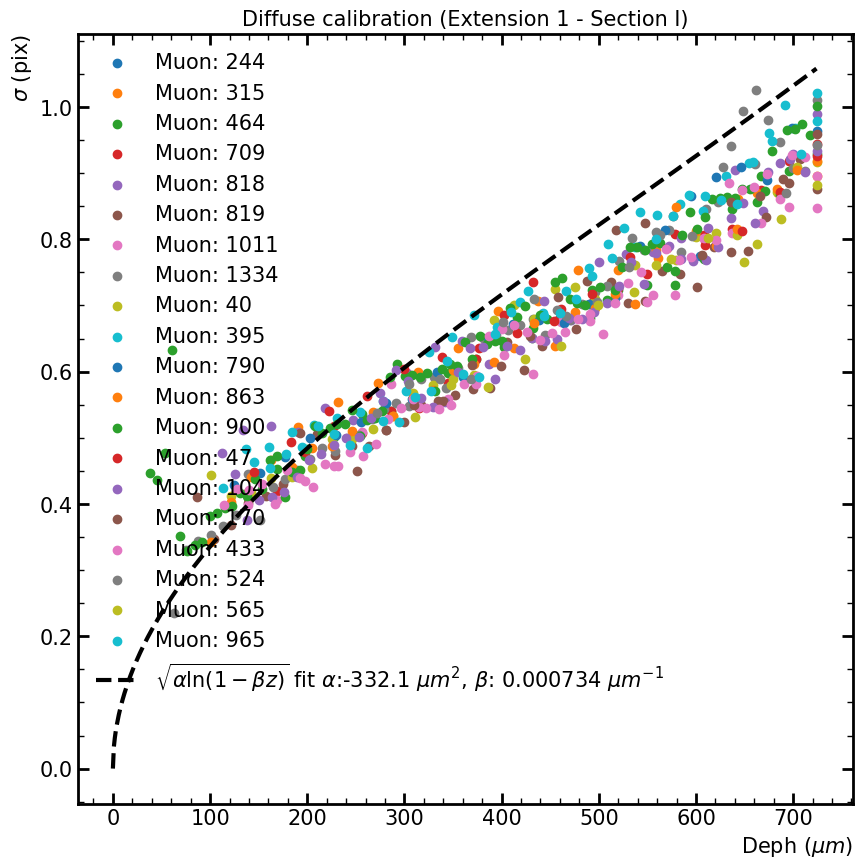

Warning in <TROOT::Append>: Replacing existing TH1: histogram (Potential memory leak).


In [43]:
CCD_depth = 725 # micras
Delta_inicial = 5    # px
Delta_final = 9     # px
Bins = 50

extension = 2
img_sigma = 0.0008  # KeV 
# print(img_sigma)
fig, axs_all = plt.subplots(figsize = [10,10])


# DAta for 0 to 5 
#  [37, 157, 244, 315, 391, 464, 513, 622, 632, 635, 636, 709, 727, 818, 819, 847, 1011, 1221, 1245, 1252, 1334]

#  Data for 355 to 360
# [17, 29, 40, 113, 203, 258, 327, 344, 376, 395, 403, 790, 802, 833, 863, 890, 900, 975, 999, 1028, 1047, 1056, 1066, 1090, 1151, 1180, 1316]

# Data for 355 to 360
# 5, 43, 47, 50, 81, 96, 104, 170, 192, 209, 219, 228, 238, 241, 246, 252, 265, 285, 313, 347, 372, 379, 388, 399, 411, 433, 442, 524, 565, 568, 
# 591, 701, 723, 766, 768, 785, 786, 821, 835, 838, 839, 841, 846, 859, 860, 879, 889, 899, 909, 921, 945, 957, 965, 986, 997, 1016, 1043, 1069, 
# 1073, 1080, 1086, 1116, 1131, 1137, 1153, 1154, 1157, 1206, 1225, 1247, 1248, 1330]

# 47, 104, 170, 209, 219, 241, 246, 252,372, 433, 524, 565, 839, 859, 921, 965, 1131, 1206, 1225 
list_muonlabels0 = [244, 315, 464,709, 818,819, 1011, 1334] # Phi 0 to 5 deg
list_muonlabels1= [40, 395, 790, 863, 900] # Phi 355 to 360
list_muonlabels2= [47, 104, 170, 433, 524, 565, 965] # Phi 175 to 185

# print(list_muonlabels0 +  list_muonlabels1)
list_muonlabels = list_muonlabels0  +  list_muonlabels1  +  list_muonlabels2 
# list_muonlabels = list_muonlabels0  +  list_muonlabels1 
# list_muonlabels = list_muonlabels2


for label_muon in list_muonlabels: 
    event = list_datamask[label_muon]
    size_x = event.shape[1]
    size_y = event.shape[0]

    # lines = 0
    Longitud_XY = size_x 
    Z_inicial = (Delta_inicial * CCD_depth) / (Longitud_XY - Delta_final)
    # print('Muon: ', label_muon, ', Shape (X, Y): ', event.shape[1], event.shape[0])

    list_fitsigmas = []
    if label_muon in list_muonlabels2:
        Delta_inicial = Delta_final
        Delta_final = Delta_inicial


    for lable_line in range(Delta_inicial, size_x - Delta_final):
        # print(label_line)
        line = event[:, lable_line: lable_line + 1]
        Carga_renglon = line.sum()
        Mean_carga = np.mean(line)
        Longitud_linea = len(line)

        Mean_in  = 0
        var = 0
        carga_cuadrada = 0

        ### Se calcula el X promedio ##
        for pixel in range(0, Longitud_linea):
            if line[pixel][0]:
                element_pixel = (pixel * line[pixel][0]) / Carga_renglon
                Mean_in = Mean_in + element_pixel
            else:
                element_pixel = 0
            
            Mean_in = Mean_in + element_pixel

        ## Calcula la suma de las cargas al cuadrado ##
        for pixel in range(0, Longitud_linea, 1):
            if line[pixel][0]:
                element_pixel = line[pixel][0]**2
            else:
                element_pixel = 0

            carga_cuadrada = carga_cuadrada + element_pixel 

        Mean_carga_cuadrada = carga_cuadrada/Longitud_linea

        ### Se calcula la varianza ##
        for pixel in range(0, Longitud_linea, 1):
            if line[pixel][0]:
                element_pixel =(1 / (Longitud_linea - 1)) * (pixel - Mean_in)**2 * line[pixel][0]
                # element_pixel =(1 / (Longitud_linea - 1)) * (pixel - Mean_in)**2
                var = var + element_pixel  ### COreggir la varianza con otro estimados

        ### Se corrige la varianza con la carga ###
        var_true = var * (Mean_carga_cuadrada / (Mean_carga**2))
        # var_true = var / Carga_renglon

        ### Se calcula la sigma ###
        sigma_in = np.sqrt(var_true)
        # print(sigma_in)
        # sigma_in = np.sqrt(var_true)


        ##Se crea un arreglo para usarlo en el plot de los datos, y se realiza el juste ##
        list_xlabel = np.arange(0.5, len(line), 1)


        ## Ajuste gaussiano con ROOT ##
        fgaus2 = TF1("fgauss","gaus",  0,  len(line), 3) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
        h3=TH1F("histogram", "Distribution of Line", len(line) + 1, 0,  len(line) )

        for index in range(0, len(line)):
            if line[index][0] != 0:
                # print(index, line[index])
                h3.SetBinContent( index + 1, line[index][0])
                h3.SetBinError(index + 1, img_sigma)
                # h3.SetBinError(index + 1, 0.001)
                #print(pixel_value)

        fgaus2.SetParameters(np.max(line),Mean_in,sigma_in) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
        h3.Fit(fgaus2, "RQN")

        fit_const = fgaus2.GetParameters()[0]
        fit_mean = fgaus2.GetParameters()[1]
        fit_sigma = fgaus2.GetParameters()[2]


        # fit_sigma = sigma_in
        # print('Sigma fit: ', fit_sigma)
        list_fitsigmas.append(fit_sigma)

        del h3

    list_deep = []
    list_xlabel_sigmas = np.linspace(Z_inicial, CCD_depth, len(list_fitsigmas))
    for deep in list_xlabel_sigmas:
        list_deep.append(deep)

    if label_muon in list_muonlabels2:
        list_fitsigmas.reverse()

    axs_all.scatter(list_deep, list_fitsigmas, label = 'Muon: ' + str(label_muon))
    # axs_all.scatter(list_deep, list_fitsigmas)


def diffution_curve(z, alpha, beta):
    return np.sqrt((alpha * np.log(1 - (beta * z))))

fit_range = np.arange(0, 725)
# fit_alpha, fit_beta = -348.2, 0.000702
Label = r'$\sqrt{\alpha \ln(1 - \beta z)}$ fit $\alpha$:' + str(np.around(fit_alpha, 1)) + r' $\mu m^{2}$, $\beta$: ' + str(np.around(fit_beta, 6)) + r' $\mu m^{-1}$'

# axs_all.plot(fit_range, diffution_curve(fit_range, alpha=-200, beta=0.001) / 15, '--r', linewidth = 3)
axs_all.plot(fit_range, diffution_curve(fit_range, alpha=fit_alpha, beta=fit_beta)/15, '--k', linewidth = 3, label= Label)
# axs_all.plot(fit_range, diffution_curve(fit_range, alpha=-292.4325743170209, beta=3.990904646095944e-06), '--c', linewidth = 2, label='Fit CONNIE')

axs_all.set_title('Diffuse calibration (Extension 1 - Section I)', size = 15)#, y=0.92)}
axs_all.set_ylabel(r'$\sigma$ (pix)')
axs_all.set_xlabel(r'Deph ($\mu m$)')
# axs_all.set_ylim(0, )
# axs_all.set_xlim(0, 725)
axs_all.legend()
axs_all.grid
plt.show()

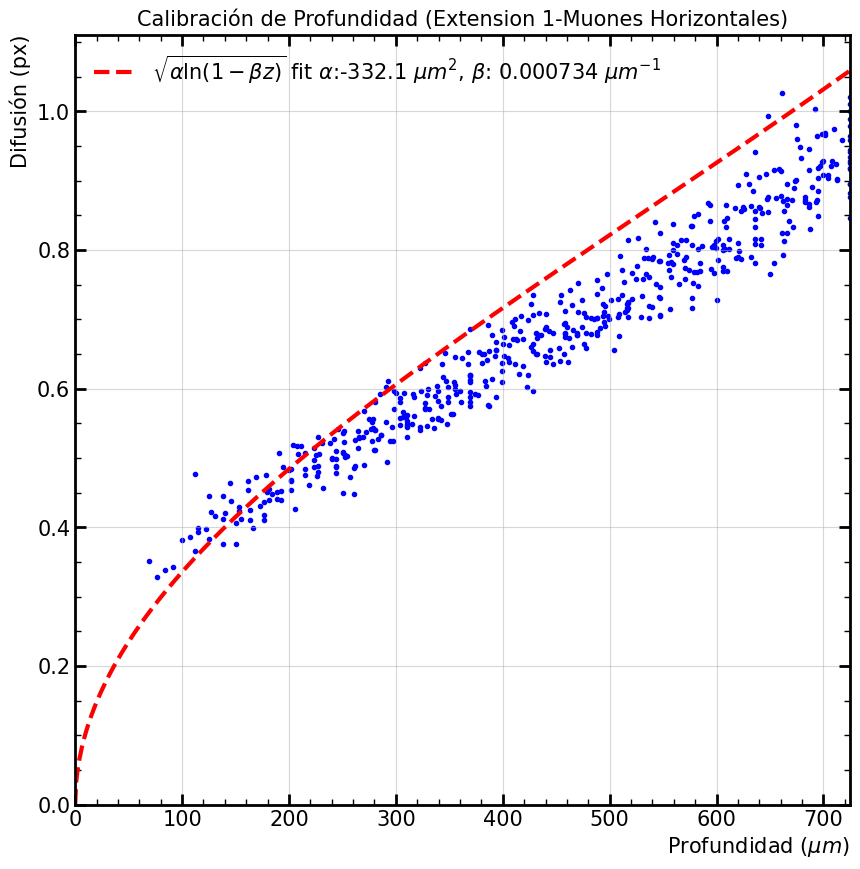

In [44]:
img_sigma = 0.0008  # KeV 
# print(img_sigma)
fig, axs_all = plt.subplots(figsize = [10,10])

# list_muonlabels = [256, 257, 258]

list_all_sigmas = []
list_all_deeps = []

for label_muon in list_muonlabels: 
    event = list_datamask[label_muon]
    size_x = event.shape[1]
    size_y = event.shape[0]

    # lines = 0
    Longitud_XY = size_x
    Z_inicial = (Delta_inicial * CCD_depth) / (Longitud_XY - Delta_final)
    # print('Muon: ', label_muon, ', Shape (X, Y): ', event.shape[1], event.shape[0])

    list_fitsigmas = []
    if label_muon in list_muonlabels2:
        Delta_inicial = Delta_final
        Delta_final = Delta_inicial

    for lable_line in range(Delta_inicial, size_x - Delta_final):
        line = event[:, lable_line: lable_line + 1]
        Carga_renglon = line.sum()
        Mean_carga = np.mean(line)
        Longitud_linea = len(line)


        Mean_in  = 0
        var = 0
        carga_cuadrada = 0

        ### Se calcula el X promedio ##
        for pixel in range(0, Longitud_linea):
            if line[pixel][0]:
                element_pixel = (pixel * line[pixel][0]) / Carga_renglon
                Mean_in = Mean_in + element_pixel
            else:
                element_pixel = 0
            
            Mean_in = Mean_in + element_pixel

        ## Calcula la suma de las cargas al cuadrado ##
        for pixel in range(0, Longitud_linea, 1):
            if line[pixel][0]:
                element_pixel = line[pixel][0]**2
            else:
                element_pixel = 0

            carga_cuadrada = carga_cuadrada + element_pixel 

        Mean_carga_cuadrada = carga_cuadrada/Longitud_linea

        ### Se calcula la varianza ##
        for pixel in range(0, Longitud_linea, 1):
            if line[pixel][0]:
                element_pixel =(1 / (Longitud_linea - 1)) * (pixel - Mean_in)**2 * line[pixel][0]
                var = var + element_pixel  ### COreggir la varianza con otro estimados

        ### Se corrige la varianza con la carga ###
        # var_true = var * (Mean_carga_cuadrada / (Mean_carga**2))
        var_true = var / Carga_renglon

        ### Se calcula la sigma ###
        sigma_in = np.sqrt(var)
        # print(sigma_in)
        # sigma_in = np.sqrt(var_true)


        ##Se crea un arreglo para usarlo en el plot de los datos, y se realiza el juste ##
        list_xlabel = np.arange(0.5, len(line), 1)


        ## Ajuste gaussiano con ROOT ##
        fgaus2 = TF1("fgauss","gaus",  0,  len(line), 3) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
        h3=TH1F("histogram", "Distribution of Line", len(line) + 1, 0,  len(line) )

        for index in range(0, len(line)):
            if line[index][0] != 0:
                # print(index, line[index])
                h3.SetBinContent( index + 1, line[index][0])
                h3.SetBinError(index + 1, img_sigma)
                # h3.SetBinError(index + 1, 0.001)
                #print(pixel_value)

        fgaus2.SetParameters(np.max(line),Mean_in,sigma_in) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
        h3.Fit(fgaus2, "RQN")

        fit_const = fgaus2.GetParameters()[0]
        fit_mean = fgaus2.GetParameters()[1]
        fit_sigma = fgaus2.GetParameters()[2]


        # fit_sigma = sigma_in
        # print('Sigma fit: ', fit_sigma)
        list_fitsigmas.append(fit_sigma)

        del h3

    list_deep = []
    list_xlabel_sigmas = np.linspace(Z_inicial, CCD_depth, len(list_fitsigmas))
    for deep in list_xlabel_sigmas:
        list_deep.append(deep)

    # if label_muon in (143, 302, 321, 362, 383, 385, 404, 434, 550, 793, 864, 929, 1090, 1091):
    #     # print('Gola', list_fitsigmas[0], list_fitsigmas[-1])
    #     list_fitsigmas.reverse()
    #     # print('Agios', list_fitsigmas[0], list_fitsigmas[-1], end='\n\n')
    if label_muon in list_muonlabels2:
        list_fitsigmas.reverse()
        
    for index in range(0, len(list_fitsigmas)):
        list_all_sigmas.append(list_fitsigmas[index])
        list_all_deeps.append(list_deep[index])

    # axs_all.scatter(list_deep, list_fitsigmas, marker='2', label = 'Muon: ' + str(label_muon))
del list_fitsigmas
del list_deep


fit_range = np.arange(0, 725)

axs_all.scatter(list_all_deeps, list_all_sigmas, marker='.', facecolor = 'b')

def diffution_curve(x, alpha, beta):
    return np.sqrt((alpha * np.log(1 - (beta * x))))

# popt_DM, _ = curve_fit(diffution_curve, list_all_deeps, list_all_sigmas, maxfev=100000, p0= [1, 1])
# dict_diffution_model = {'Alpha' : popt_DM[0], 'Beta' : popt_DM[1]}
# print('Alpha: ', dict_diffution_model['Alpha'], ' Beta: ', dict_diffution_model['Beta'])



axs_all.plot(fit_range, diffution_curve(fit_range, alpha=fit_alpha, beta=fit_beta)/15, '--r', linewidth = 3, label= Label)
# axs_all.plot(fit_range, diffution_curve(fit_range, -611, 0.00045)/15, '--r', linewidth = 3)

axs_all.set_title('Calibración de Profundidad (Extension 1-Muones Horizontales)', size = 15)#, y=0.92)}
axs_all.set_ylabel(r'Difusión (px)')
axs_all.set_xlabel(r'Profundidad ($\mu m$)')
axs_all.set_ylim(0,)
axs_all.set_xlim(0, 725)
axs_all.legend()
axs_all.grid()
plt.show()

In [45]:
list_all_sigmas = []
list_all_deeps = []

for label_muon in list_muonlabels: 
    event = list_datamask[label_muon]
    size_x = event.shape[1]
    size_y = event.shape[0]

    # lines = 0
    Longitud_XY = size_x
    Z_inicial = (Delta_inicial * CCD_depth) / (Longitud_XY - Delta_final)
    # print('Muon: ', label_muon, ', Shape (X, Y): ', event.shape[1], event.shape[0])

    list_fitsigmas = []
    if label_muon in list_muonlabels2:
        Delta_inicial = Delta_final
        Delta_final = Delta_inicial

    for lable_line in range(Delta_inicial, size_x - Delta_final):
        line = event[:, lable_line: lable_line + 1]
        Carga_renglon = line.sum()
        Mean_carga = np.mean(line)
        Longitud_linea = len(line)


        Mean_in  = 0
        var = 0
        carga_cuadrada = 0

        ### Se calcula el X promedio ##
        for pixel in range(0, Longitud_linea):
            if line[pixel][0]:
                element_pixel = (pixel * line[pixel][0]) / Carga_renglon
                Mean_in = Mean_in + element_pixel
            else:
                element_pixel = 0
            
            Mean_in = Mean_in + element_pixel

        ## Calcula la suma de las cargas al cuadrado ##
        for pixel in range(0, Longitud_linea, 1):
            if line[pixel][0]:
                element_pixel = line[pixel][0]**2
            else:
                element_pixel = 0

            carga_cuadrada = carga_cuadrada + element_pixel 

        Mean_carga_cuadrada = carga_cuadrada/Longitud_linea

        ### Se calcula la varianza ##
        for pixel in range(0, Longitud_linea, 1):
            if line[pixel][0]:
                element_pixel =(1 / (Longitud_linea - 1)) * (pixel - Mean_in)**2 * line[pixel][0]
                var = var + element_pixel  ### COreggir la varianza con otro estimados

        ### Se corrige la varianza con la carga ###
        # var_true = var * (Mean_carga_cuadrada / (Mean_carga**2))
        var_true = var / Carga_renglon

        ### Se calcula la sigma ###
        sigma_in = np.sqrt(var)
        # print(sigma_in)
        # sigma_in = np.sqrt(var_true)


        ##Se crea un arreglo para usarlo en el plot de los datos, y se realiza el juste ##
        list_xlabel = np.arange(0.5, len(line), 1)


        ## Ajuste gaussiano con ROOT ##
        fgaus2 = TF1("fgauss","gaus",  0,  len(line), 3) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
        h3=TH1F("histogram", "Distribution of Line", len(line) + 1, 0,  len(line) )

        for index in range(0, len(line)):
            if line[index][0] != 0:
                # print(index, line[index])
                h3.SetBinContent( index + 1, line[index][0])
                h3.SetBinError(index + 1, img_sigma)
                # h3.SetBinError(index + 1, 0.001)
                #print(pixel_value)

        fgaus2.SetParameters(np.max(line),Mean_in,sigma_in) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
        h3.Fit(fgaus2, "RQN")

        fit_const = fgaus2.GetParameters()[0]
        fit_mean = fgaus2.GetParameters()[1]
        fit_sigma = fgaus2.GetParameters()[2]


        # fit_sigma = sigma_in
        # print('Sigma fit: ', fit_sigma)
        list_fitsigmas.append(fit_sigma)

        del h3

    list_deep = []
    list_xlabel_sigmas = np.linspace(Z_inicial, CCD_depth, len(list_fitsigmas))
    for deep in list_xlabel_sigmas:
        list_deep.append(deep)

    if label_muon in list_muonlabels2:
        list_fitsigmas.reverse()

    for index in range(0, len(list_fitsigmas)):
        list_all_sigmas.append(list_fitsigmas[index])
        list_all_deeps.append(list_deep[index])

    # axs_all.scatter(list_deep, list_fitsigmas, marker='2', label = 'Muon: ' + str(label_muon))
del list_fitsigmas
del list_deep



# fit_range = np.arange(0, 900)
# axs_all.scatter(list_all_deeps, list_all_sigmas, marker='2')
 
h_model = TGraph(len(list_all_sigmas), np.array(list_all_deeps),np.array(list_all_sigmas))
h_model.SetMarkerStyle(2) # Set marker style (e.g., solid circle)
h_model.SetTitle("Modelo de dif. (Extensión 2 - Muones Horizontales)")
h_model.GetXaxis().SetTitle("Profundidad (micras)")
h_model.GetYaxis().SetTitle("Anchura (micras)")
h_model.SetStats()
h_model.GetXaxis().SetRangeUser(0, 725)
h_model.GetYaxis().SetRangeUser(0, 1.2)



Range_fit = [0, 725]
diff_curve = TF1("diff_curve", "sqrt(([0] * log(1 - [1]*x)))/15", Range_fit[0], Range_fit[1], 2) #np.sqrt(np.abs(alpha * np.log(1 - (beta * z))))

diff_curve.SetParameters(-200, 0.00001) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
h_model.Fit(diff_curve, "RNQ")

fit_alpha = diff_curve.GetParameters()[0]
fit_beta = diff_curve.GetParameters()[1]
chi2 = diff_curve.GetChisquare()
ndf = diff_curve.GetNDF()
prob = diff_curve.GetProb()

fit_alpha_err = diff_curve.GetParErrors()[0]
fit_beta_err = diff_curve.GetParErrors()[1]

print('Alpha: ', fit_alpha, '+- ', fit_alpha_err) 
print('Beta: ', fit_beta,  '+- ', fit_beta_err)
print('Chi2/ndf: ', chi2, '/', ndf)
print('Prob: ', prob)




c3=TCanvas("","", 1000, 600)
h_model.Draw("AP same")
diff_curve.Draw("same")
c3.Draw()

leg = TLegend(0.1,0.7,0.48,0.9)
leg.AddEntry(diff_curve, r"\sqrt{\alpha \log(1 - \beta z)} fit: \alpha= " + str(np.around(fit_alpha, 3)) + r" \mu m^2, \beta= " + str(np.around(fit_beta, 6)) + " \mu m^{-1}", "L")
leg.Draw()


Alpha:  -492.3436562231453 +-  56.04493196451444
Beta:  0.0004402028680291546 +-  4.372938876385827e-05
Chi2/ndf:  0.7925180397002676 / 535
Prob:  1.0


In [46]:
from array import array

spread_array = array('f', [-9999])
deep_array = array('f', [-9999])

location_file = './'
file_root_name = 'tree_DiffusionMod_Ext2_Horz.root'
file = TFile.Open(location_file  + file_root_name, "RECREATE")
tree = TTree('tree', 'tree')

tree.Branch('sprd', spread_array, 'sprd/F')
tree.Branch('deep', deep_array, 'deep/F')

for i in range(0, len(list_all_sigmas)):
    spread_array[0] = list_all_sigmas[i]
    deep_array[0] = list_all_deeps[i]
    
    tree.Fill()

tree.Write()
file.Close()

### Ajustes horizontal y vertical

In [238]:
Range_fit = [0, 725]
diff_curve_1 = TF1("diff_curve_1", "sqrt(([0] * log(1 - [1]*x)))/15", Range_fit[0], Range_fit[1], 2)
diff_curve_1.SetParameters(-492.344, 0.00044)
diff_curve_1.SetLineColor(2)
diff_curve_1.SetTitle("Modelo de Difusión (Ext 2)")
diff_curve_1.GetXaxis().SetTitle("Profundidad (micras)")
diff_curve_1.GetYaxis().SetTitle("Anchura (px)")
diff_curve_1.GetYaxis().SetRangeUser(0, 1.6)

diff_curve_2 = TF1("diff_curve_2", "sqrt(([0] * log(1 - [1]*x)))/15", Range_fit[0], Range_fit[1], 2)
diff_curve_2.SetParameters(-332.053, 0.000734)
diff_curve_2.SetLineColor(4)
diff_curve_2.GetYaxis().SetRangeUser(0, 1.6)

c3=TCanvas("","", 1000, 600)
diff_curve_1.Draw()
diff_curve_2.Draw("same")

leg = TLegend(0.1,0.7,0.48,0.9)
leg.AddEntry(diff_curve_1, "Muones Horizontales", "L")
leg.AddEntry(diff_curve_2, "Muones Verticales", "L")
leg.Draw()

c3.Draw()

# Extensiones juntas

In [239]:
### ====== Extension 1 ===== ###
Range_fit = [0, 725]
diff_curve_1 = TF1("diff_curve_1", "sqrt(([0] * log(1 - [1]*x)))/15", Range_fit[0], Range_fit[1], 2)
diff_curve_1.SetParameters(-804.301, 0.000339)
diff_curve_1.SetLineColor(1)
diff_curve_1.SetTitle("Modelo de Difusión (Ext 1 y 2)")
diff_curve_1.GetXaxis().SetTitle("Profundidad (micras)")
diff_curve_1.GetYaxis().SetTitle("Anchura (px)")

diff_curve_2 = TF1("diff_curve_2", "sqrt(([0] * log(1 - [1]*x)))/15", Range_fit[0], Range_fit[1], 2)
diff_curve_2.SetParameters(-2400.842, 0.000126)
diff_curve_2.SetLineColor(2)

### ===== Extension 2 ===== ###
diff_curve_3 = TF1("diff_curve_3", "sqrt(([0] * log(1 - [1]*x)))/15", Range_fit[0], Range_fit[1], 2)
diff_curve_3.SetParameters(-492.344, 0.00044)
diff_curve_3.SetLineColor(3)

diff_curve_4 = TF1("diff_curve_4", "sqrt(([0] * log(1 - [1]*x)))/15", Range_fit[0], Range_fit[1], 2)
diff_curve_4.SetParameters(-332.053, 0.000734)
diff_curve_4.SetLineColor(4)
diff_curve_4.GetYaxis().SetRangeUser(0, 1.6)


c3=TCanvas("","", 1000, 600)
diff_curve_1.Draw()
diff_curve_2.Draw("same")
diff_curve_3.Draw("same")
diff_curve_4.Draw("same")

leg = TLegend(0.1,0.7,0.48,0.9)
leg.AddEntry(diff_curve_1, "Muones Horizontales (Ext1)", "L")
leg.AddEntry(diff_curve_2, "Muones Verticales (Ext1)", "L")
leg.AddEntry(diff_curve_3, "Muones Horizontales (Ext2)", "L")
leg.AddEntry(diff_curve_4, "Muones Verticales (Ext2)", "L")
leg.Draw()

c3.Draw()




### Verticales y Horizontales